# 0.0. Imports

In [36]:
from tabulate import tabulate
import psycopg2 as pg
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt
import pickle
from IPython.core.display  import HTML
import seaborn as sns
import pandas.io.sql as psql
import os
from IPython.core.display import Image
from scipy                import stats           as ss
from matplotlib import pyplot as plt
import xgboost           as xgb
from sklearn.ensemble     import RandomForestRegressor
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta               import BorutaPy
from sklearn.naive_bayes  import GaussianNB
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
from lightgbm             import LGBMClassifier
from pandas_profiling     import ProfileReport


from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import metrics         as m

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'

# 0.1. Helper Function

In [34]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def models_train(models,x_train,y_train,x_test,y_test,predict='predict',metric='regression',verbose=1):
    metrics=pd.DataFrame()
    for model in models:
        print(model.__class__.__name__)
        model.fit(x_train,y_train)
        if predict=='predict':
            yhat=model.predict(x_test)
        elif predict=='predict_proba':
            yhat=model.predict_proba(x_test)
            yhat=yhat[:, 1]
        
        if metric=='regression':
            metrics=metrics.append(regression_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='multiClass':
            metrics=metrics.append(multi_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='binaryClass':
            metrics=metrics.append(ranking_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
            
    return metrics

def ranking_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #AUC_ROC
    roc=m.roc_auc_score(y_val,yhat)
    rocdf=pd.DataFrame([roc])
    
    #topk Score
    knum=y_val.value_counts().count()-1
    topk=m.top_k_accuracy_score(y_val,yhat,k=knum)
    topkdf=pd.DataFrame([topk])    
    
    metrics = pd.concat([model,rocdf,topkdf]).T.reset_index()
    metrics.columns=['Index','Model','ROC AUC','Top K Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('ROC AUC: {}'.format(roc))
        print('Top K Score: {}'.format(topk))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

def cross_validation(num_folds,modelName,model,x,y,metric):
    kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=seed)

    cv_rf_metrics_list=pd.DataFrame()

    i=1

    for train_cv,val_cv in kfold.split(x_train,y_train):
        print('Fold Number {}/{}'.format(i,num_folds))

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model=model_fit.predict(x_val_fold)
        #metrics = model_metrics(modelName,y_val_fold,yhat_model,0)
        cv_rf_metrics_list = cv_rf_metrics_list.append(metric('{} - {}/{}'.format(modelName,i,num_folds),y_val_fold,yhat_model,0))

        i+=1
    return cv_rf_metrics_list

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    na_resume = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    na_resume.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return na_resume

def regression_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T
    
    #Accuracy
    acc = m.accuracy_score(y_val,yhat)
    accdf = pd.DataFrame([acc]).T

    #Balanced Accuracy
    balanced= m.balanced_accuracy_score(y_val,yhat)
    balanceddf = pd.DataFrame([balanced]).T

    #Kappa Metrics
    kappa= m.cohen_kappa_score(y_val, yhat)
    kappadf = pd.DataFrame([kappa]).T
    
    metrics = pd.concat([model,accdf,balanceddf,kappadf]).T.reset_index()
    metrics.columns=['Index','Model','Accuracy','Balanced Accuracy','Kappa Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Accuracy: {}'.format(acc))
        print('Balanced Accuracy: {}'.format(balanced))
        print('Kappa Score: {}'.format(kappa))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

def multi_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #Precision Score
    precision= m.precision_score(y_val, yhat)
    precisiondf = pd.DataFrame([precision]).T
    
    #Recall Score
    recall= m.recall_score(y_val, yhat)
    recalldf = pd.DataFrame([recall]).T
    
    #F1 Score
    f1= m.f1_score(y_val, yhat)
    f1df = pd.DataFrame([f1]).T
    
    #MAtthews Correlation
    mcc=m.matthews_corrcoef(y_val,yhat)
    mccdf=pd.DataFrame([mcc])    
    
    metrics = pd.concat([model,precisiondf,recalldf,f1df,mccdf]).T.reset_index()
    metrics.columns=['Index','Model','Precision Score','Recall Score','F1 Score','Matthew Correlation Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Precision Score: {}'.format(precision))
        print('Recall Score: {}'.format(recall))
        print('F1 Score: {}'.format(f1))
        print('Matthew Correlation Score: {}'.format(mcc))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

def precision_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['precision_at_k']=df[target].cumsum()/df['ranking']
    return df.loc[k,'precision_at_k']

def recall_at_k(df,yhat_proba,target,perc=0.25):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['recall_at_k']=df[target].cumsum()/df[target].sum()
    return df.loc[k,'recall_at_k']

def topK_performance(df,probas,response,perc):
    df_final_performance=pd.DataFrame()
    for i in probas:   
        for j in perc:
            k=int(np.floor(len(df_mp)*j))

            df_tg=df.copy()
            target_total=df_tg[response].sum()
            df_tg['score']= i[:,1].tolist()
            df_tg=df_tg.sort_values('score',ascending=False)
            target_at_k=df_tg[response][:k].sum()
            target_perc=target_at_k/target_total

            precision=precision_at_k(df,i,response,j)
            recall=recall_at_k(df,i,response,j)

            df_final_performance=df_final_performance.append({'Model':'Model','perc':j,'k':k,'precision':precision,'recall':recall,'target_total':target_total,'target_at_k':target_at_k,'perc_target':target_perc},ignore_index=True)
    return df_final_performance

In [6]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Load dataset

In [7]:
# Credenciais do Banco de dados Postgress
param_dict={
    'USER': os.getenv('USER_CDS'),
    'HOST': os.getenv('HOST_CDS'),
    'PORT': os.getenv('PORT_NUM'),
    'DATABASE': os.getenv('DATABASE_CDS'),
    'PWD': os.getenv('PWD_CDS')
}

# Acessando os dados com SQL

conn = pg.connect(user=param_dict['USER'],
                  password= param_dict['PWD'],
                  host=param_dict['HOST'],
                  port=param_dict['PORT'],
                  database=param_dict['DATABASE'])

#SELECT nspname
#FROM pg_catalog.pg_namespace pn 

#select tablename
#from pg_catalog.pg_tables
#where schemaname = 'pa004

query ='''
SELECT *
FROM pa004.users u inner join pa004.vehicle v on (u.id=v.id)
                   inner join pa004.insurance i on (u.id = i.id)
'''
df_raw=psql.read_sql(query, conn)
#df_raw= df_raw.drop(df_raw.columns[[5,9]], axis=1)
conn.close()



# 1.0. Data Description

In [8]:
df_aux= df_raw.copy
df1 = df_raw.copy()

df1= df1.drop(df1.columns[[5]], axis=1)
df1['id']=df_raw.iloc[:,0]


## 1.1. Rename Columns

In [9]:
df1 = df1[['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']]



## 1.2. Data Dimensions

In [10]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check Data

### 1.4.1 Check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.4.2 Check Balanced Data

In [13]:
df1['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.5. Data Descriptive

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1. Numerical Attributes

In [15]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


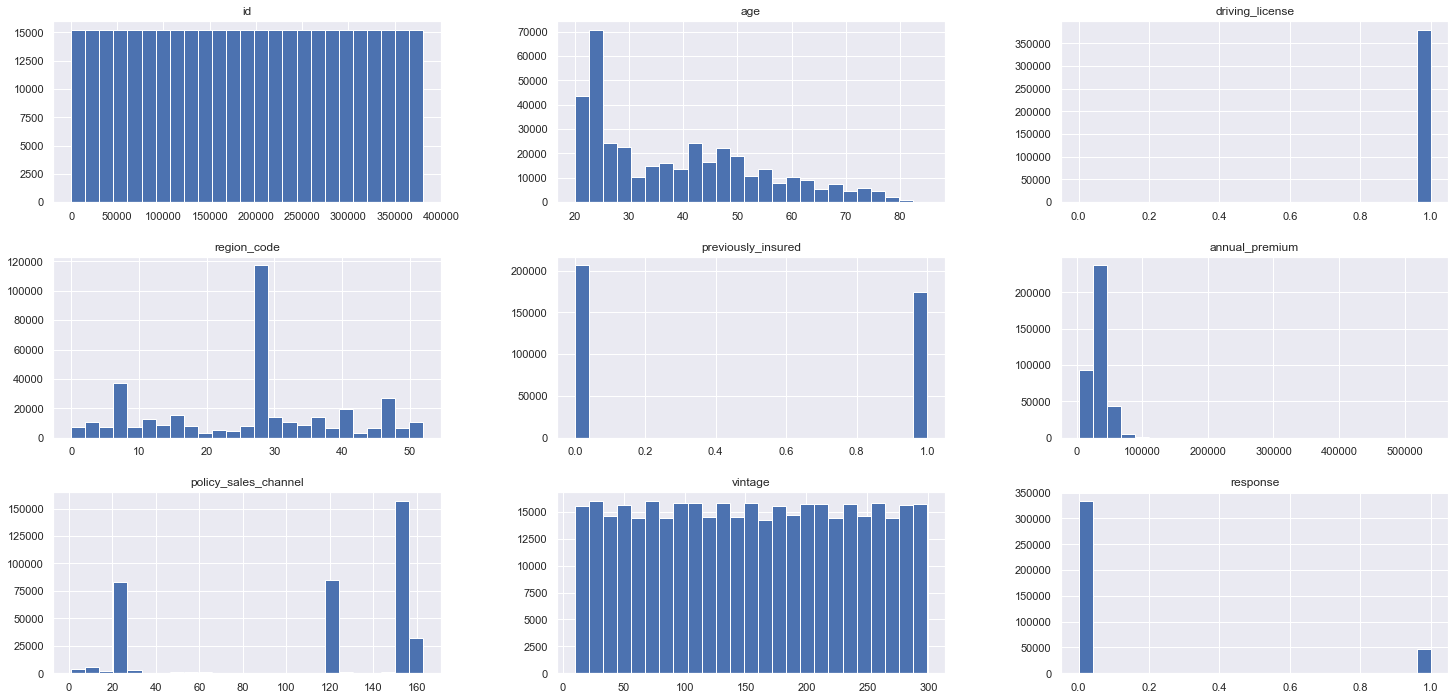

In [16]:
num_attributes.hist(bins=25);

## 1.5.2 Categorical Attributes

In [17]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


# 2.0. Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 Hypotheses Mindmap

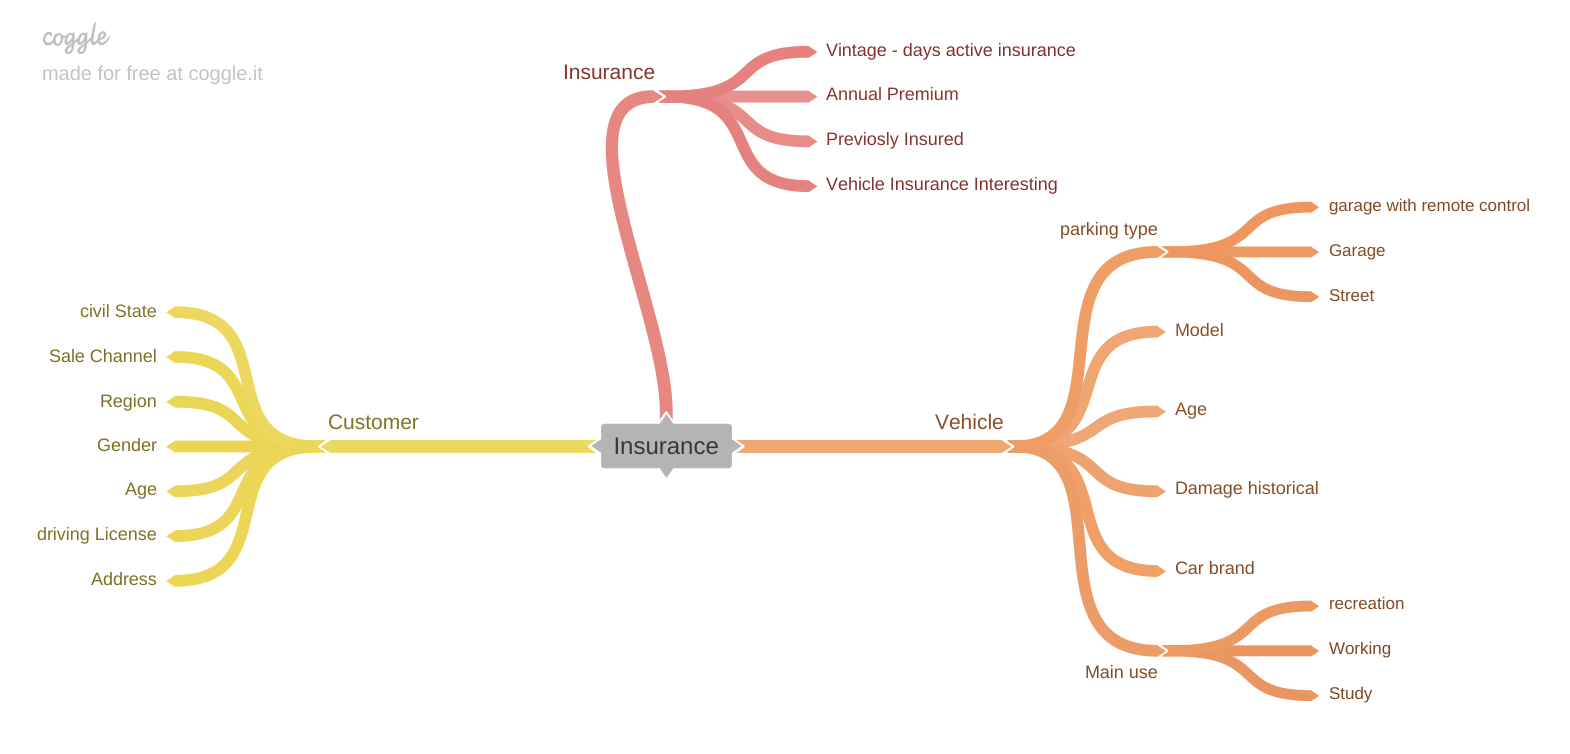

In [18]:
Image('/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/images/MindMap.png')

## 2.1.2 Hypothesis

 **H1 -** Mulheres compram mais carros que homens.
 
 **H2 -** Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.
 
 **H3 -** Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.
 
 **H4 -** Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.
 
 **H5 -** Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos. 
 
 **H6 -** Clientes que pagaram entre 24405 e 395400 para serem premium no ano(Annual Premium) tem mais interesse em adquirir seguro de veículos.
 
 **H7 -** Homens tem mais eventos de dano a veículos, do que mulheres. 

## 2.1.3 Feature Engineering

In [19]:
# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0. Data Filtering

In [22]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis

In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


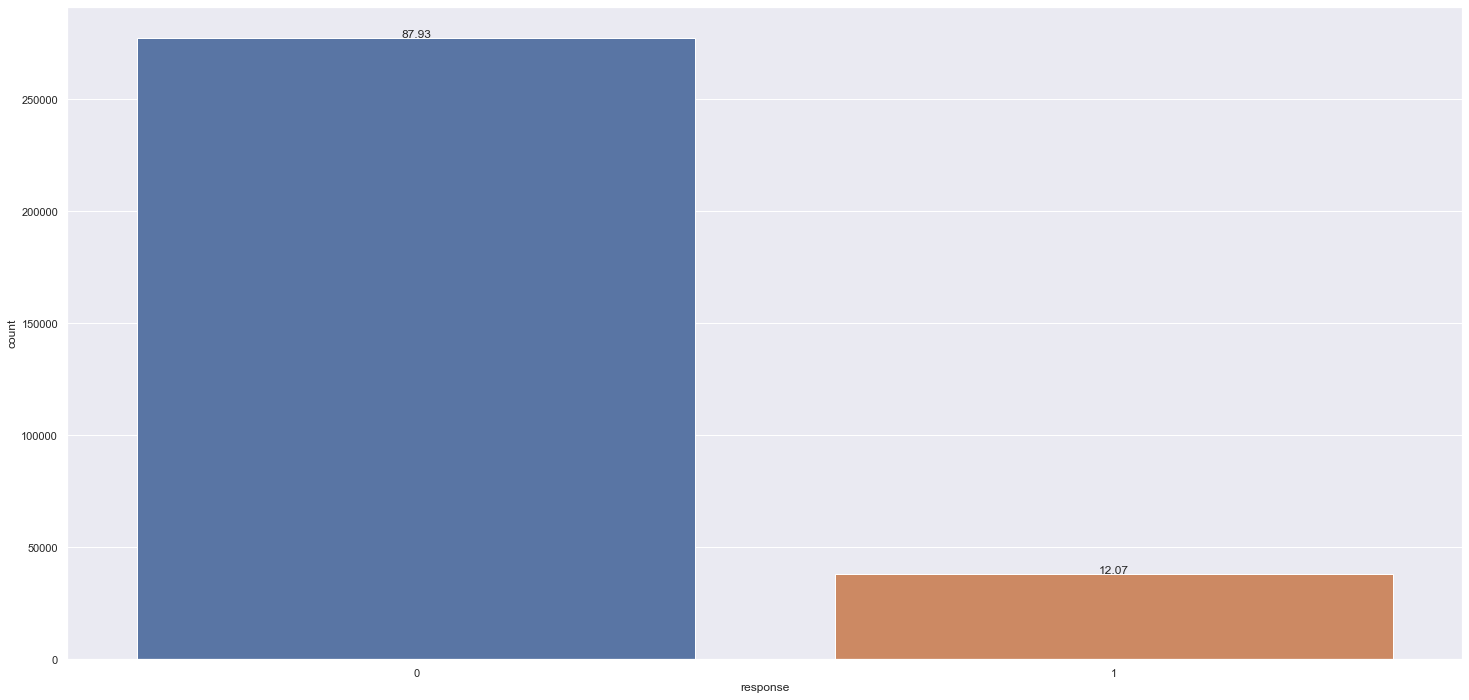

In [67]:
ax=sns.countplot(df4['response'])
total=len(df4['response'])
graphic_percentage(ax,total)

### 4.1.2. Age

<AxesSubplot:xlabel='response', ylabel='age'>

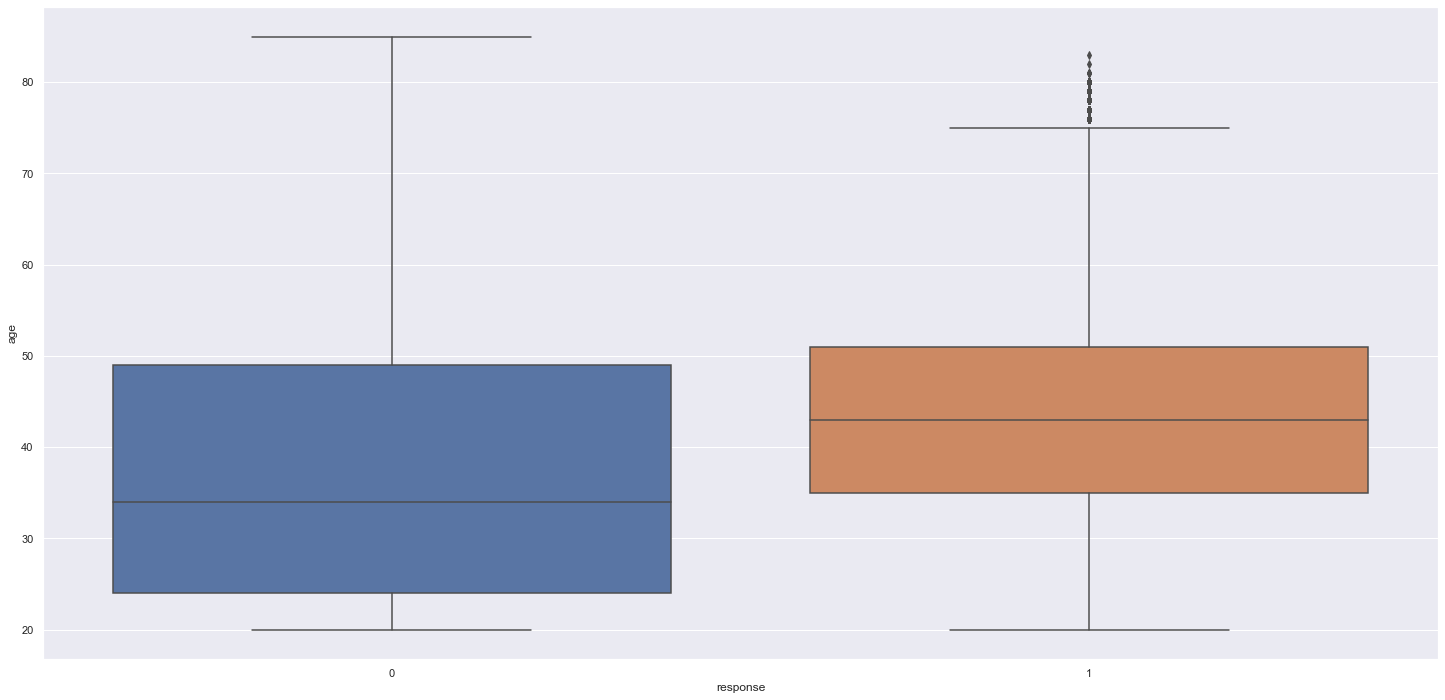

In [32]:
sns.boxplot( x='response', y='age', data=df4 )

<AxesSubplot:xlabel='age', ylabel='Count'>

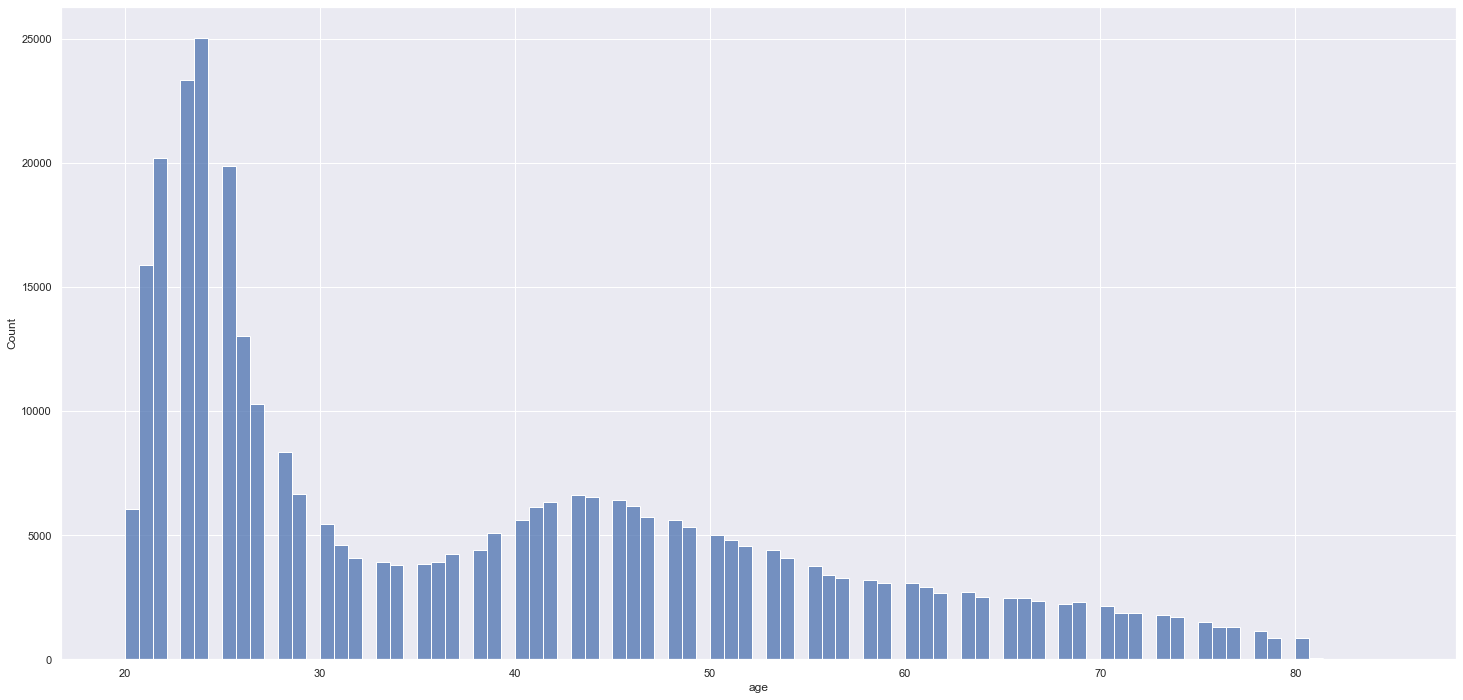

In [33]:
# Histograma de idade para respostas negativas
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

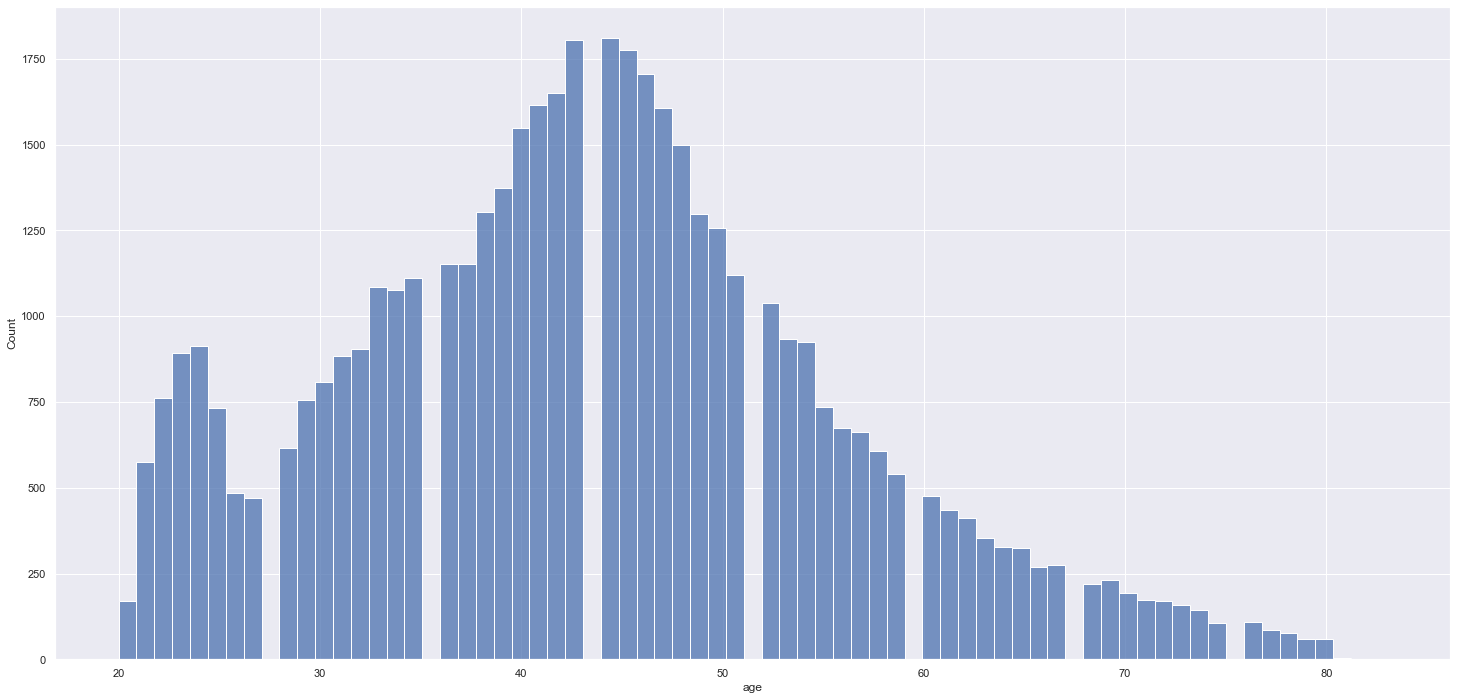

In [34]:
# Histograma de idade para respostas positivas
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

### 4.1.3. Anual Income

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

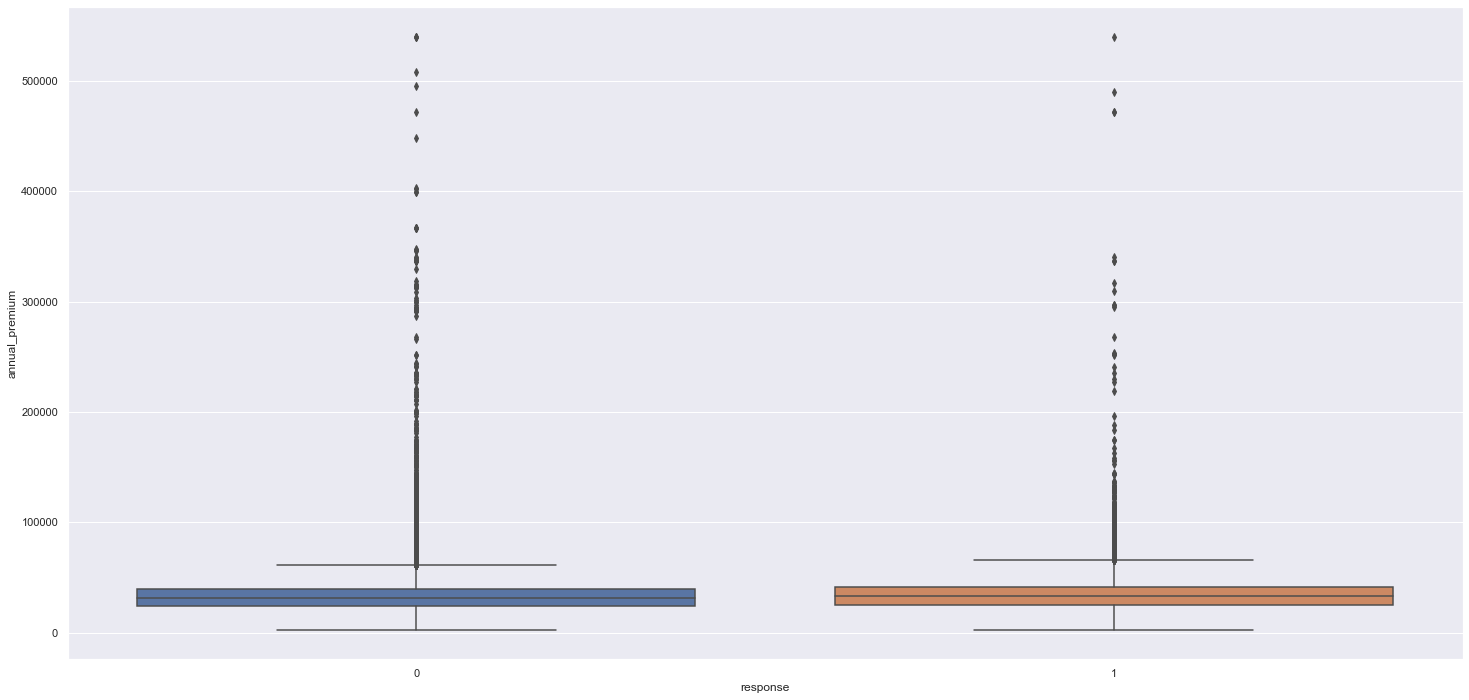

In [35]:
sns.boxplot( x='response', y='annual_premium', data=df4 )

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

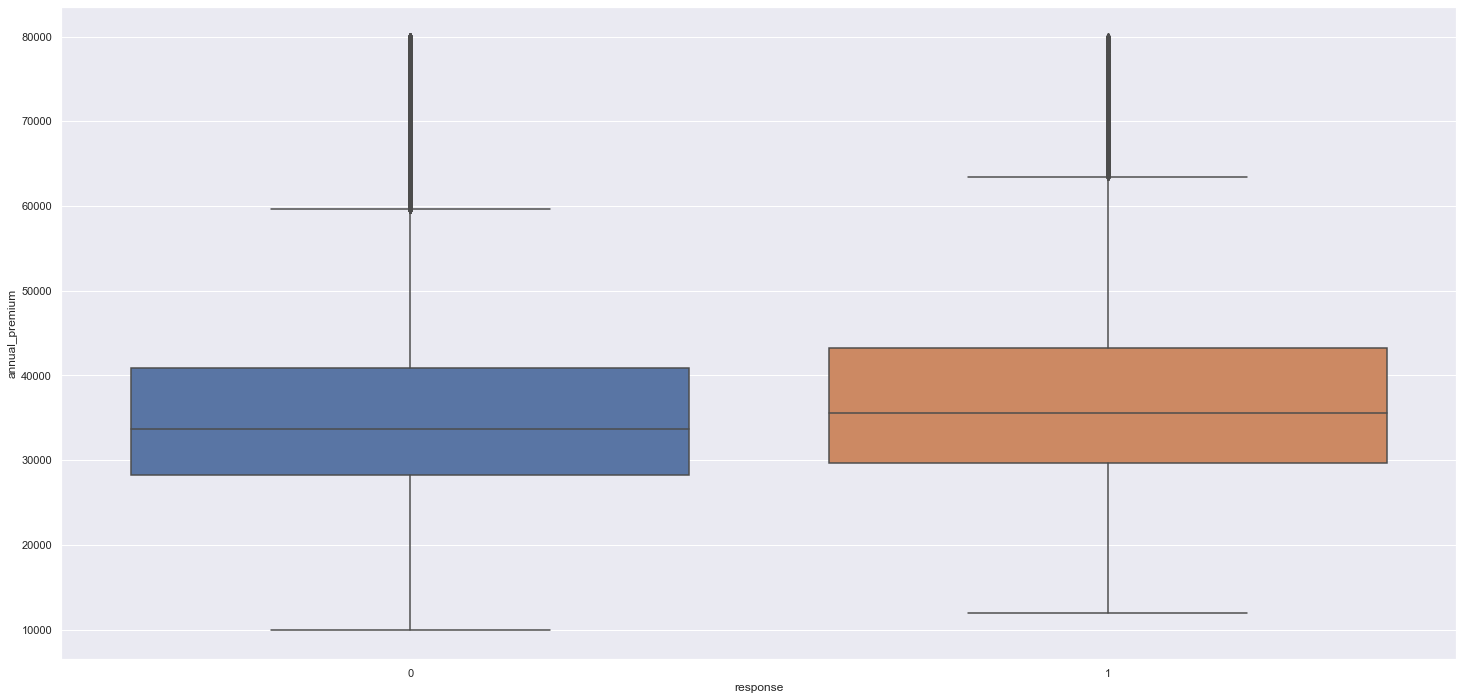

In [52]:
# Fora da margem de outliers
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

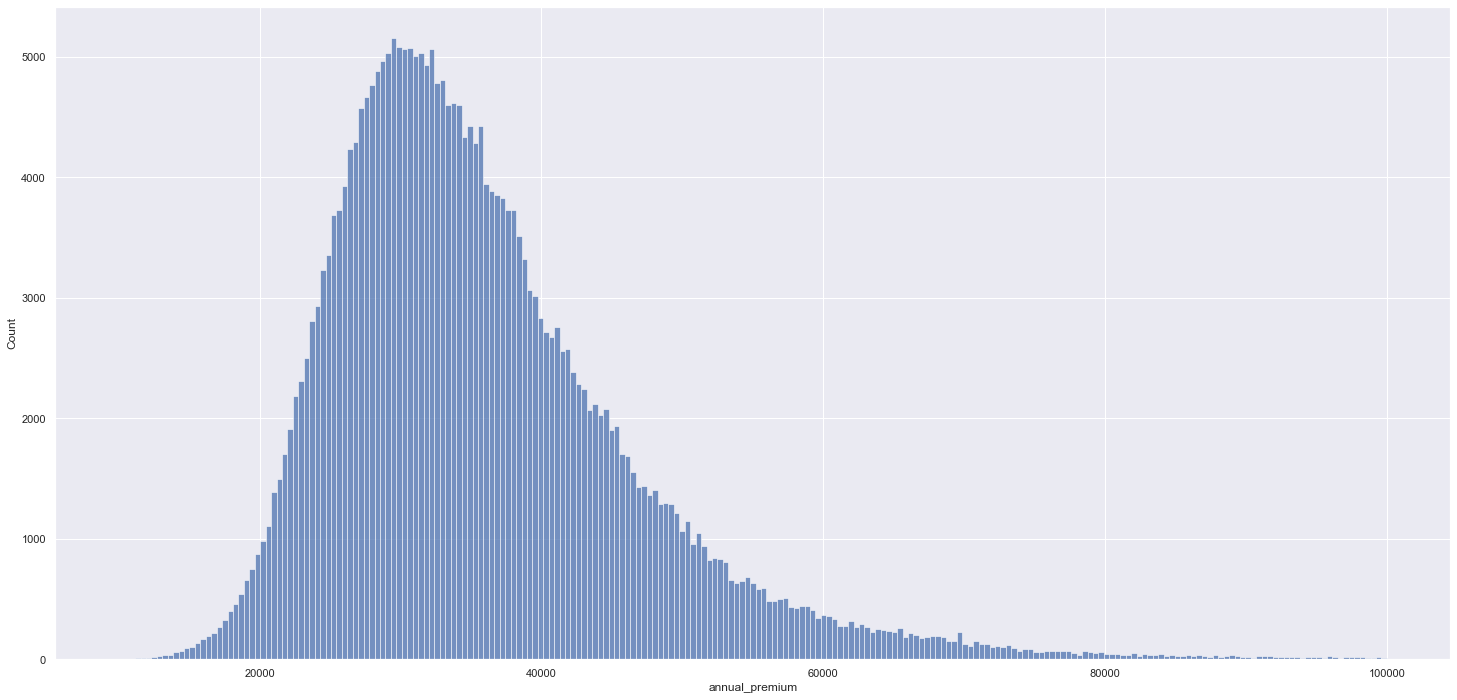

In [51]:
# Histograma para respostas negativas
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

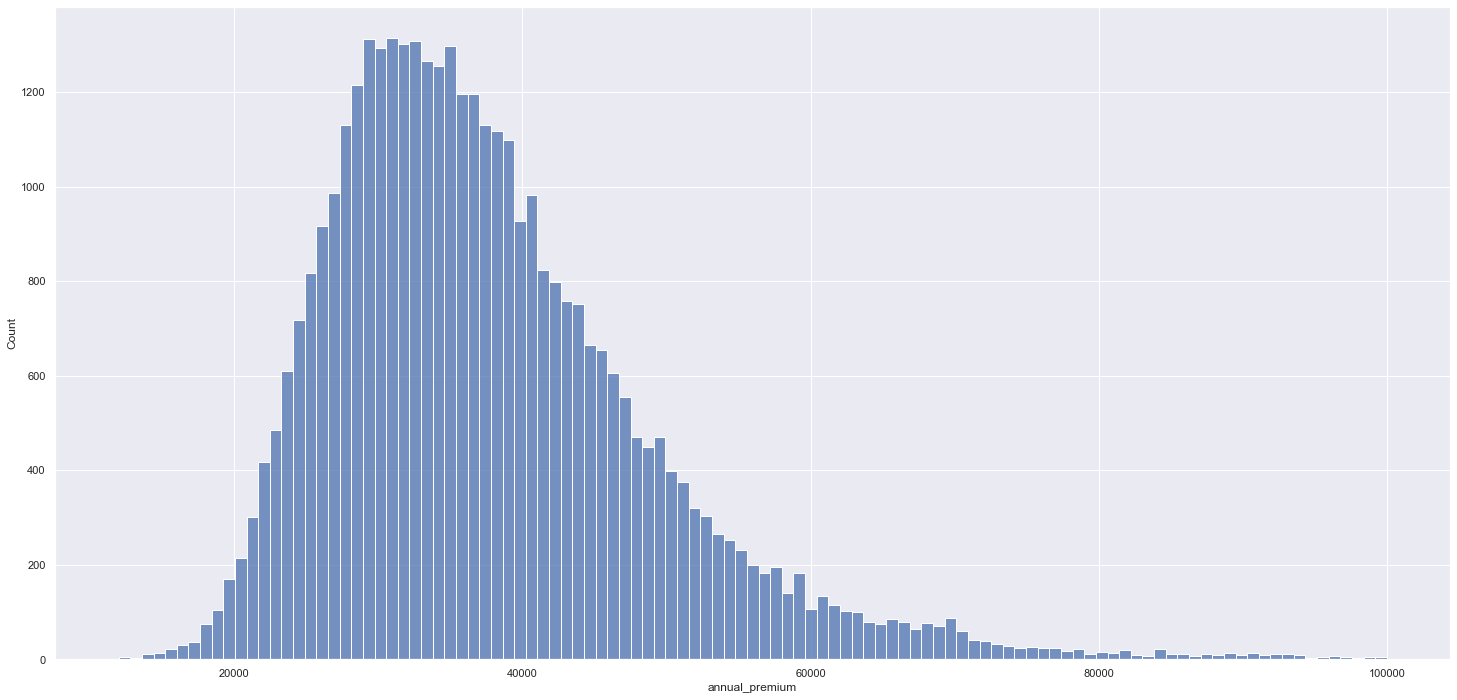

In [53]:
# Histograma para respostas positivas
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

### 4.1.4. Driving License

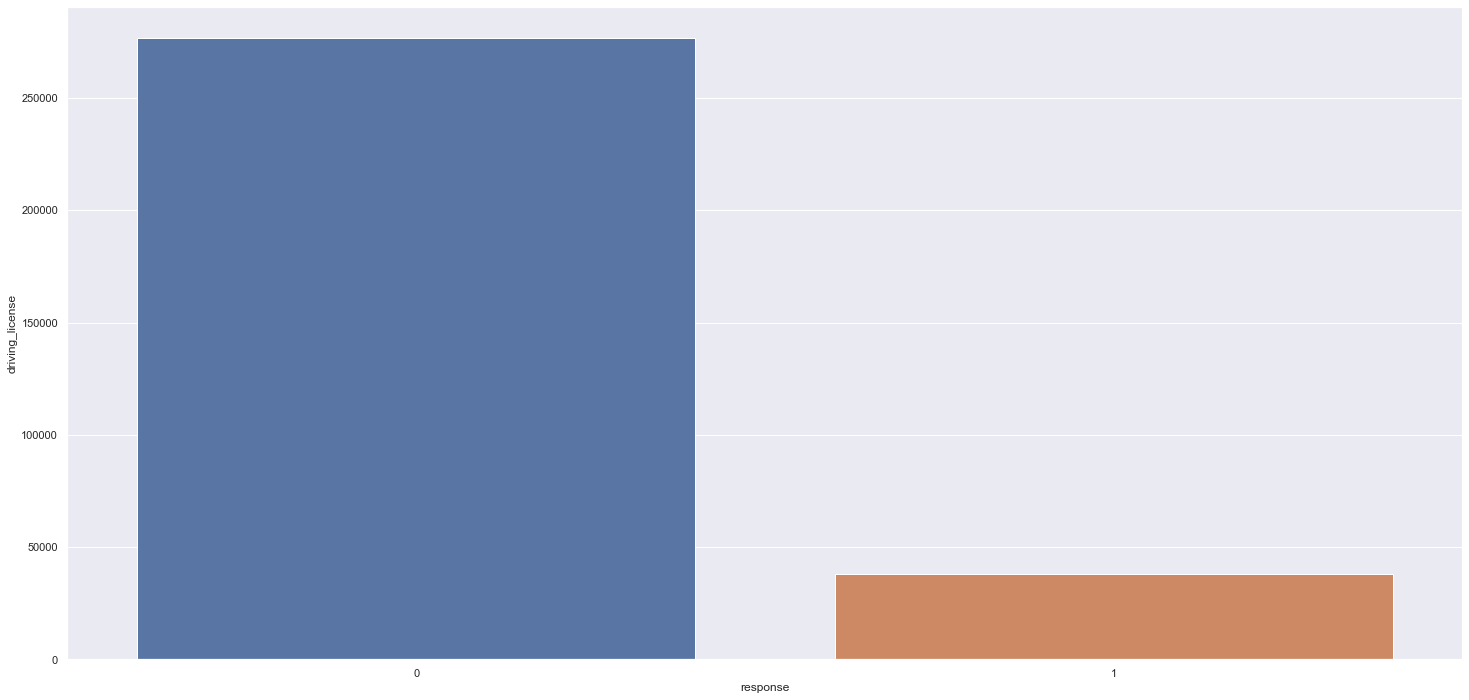

In [38]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.5. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

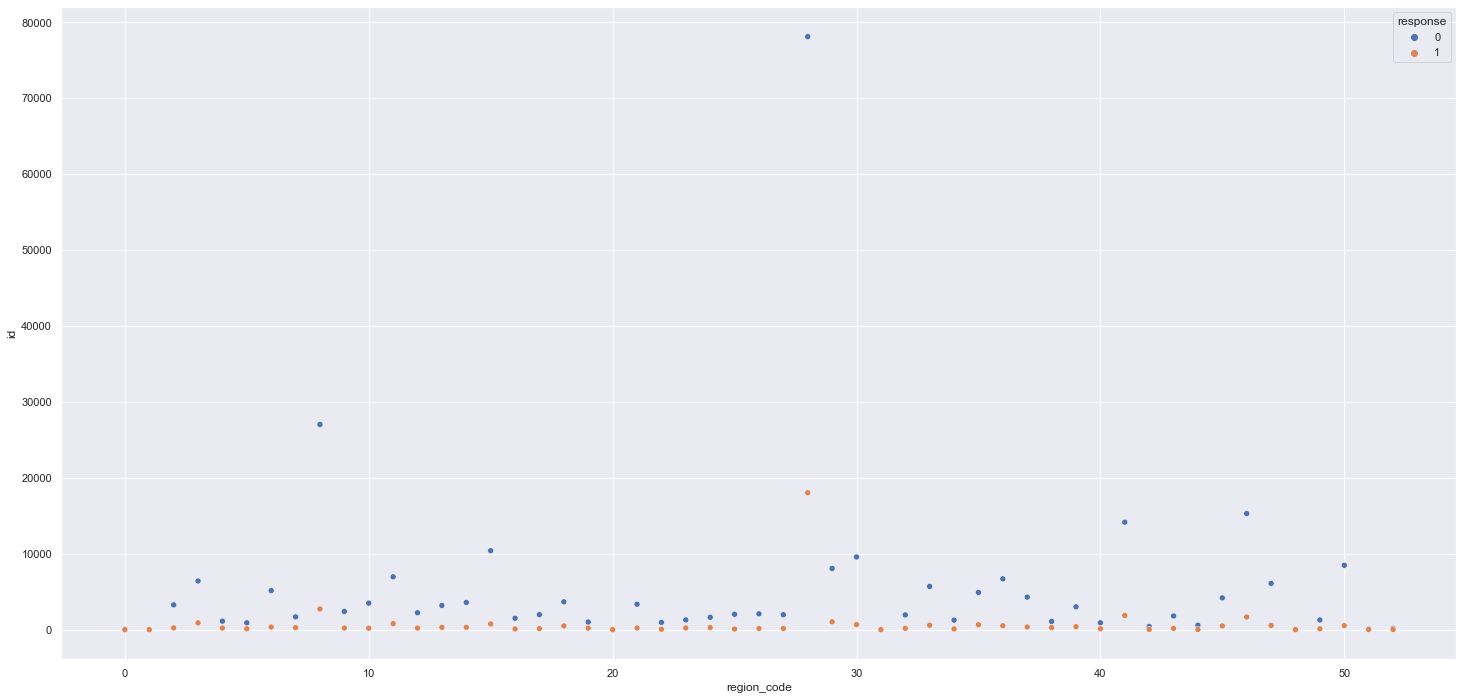

In [55]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
# aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

### 4.1.6. Previously Insured

In [41]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


### 4.1.7. Vehicle Age

In [42]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,137861
1,below_1_year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


### 4.1.8. Vehicle Damage

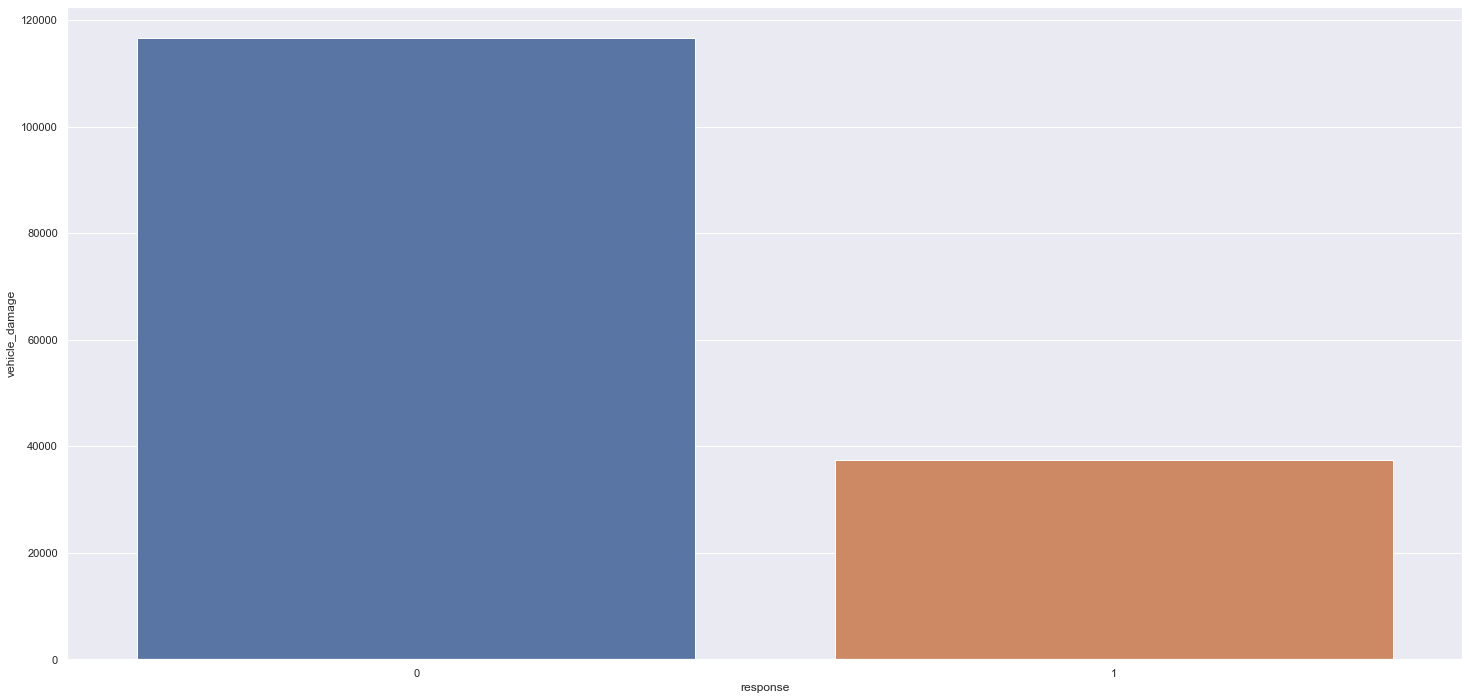

In [43]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.9. Policy Sales Channel - Stacked Percentage Bar

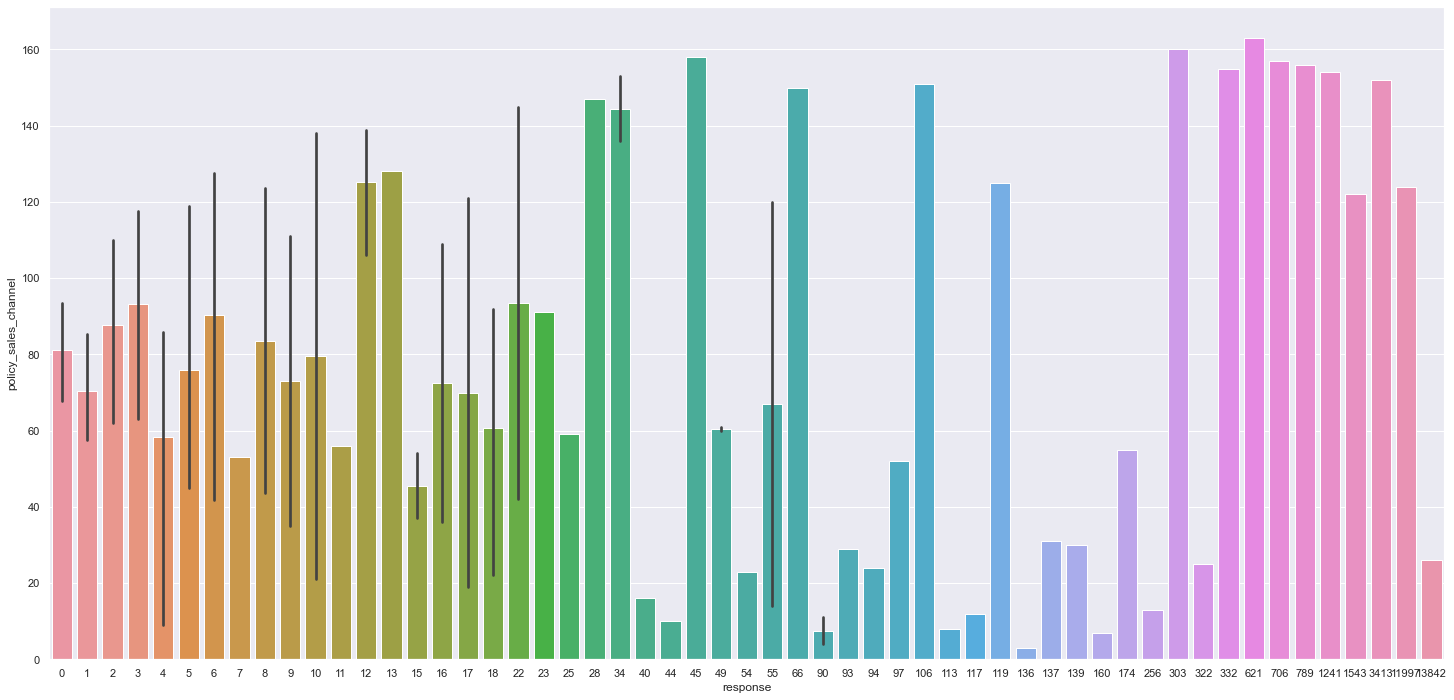

In [44]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

In [63]:
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux

,policy_sales_channel,response,total_responses
0,1.0,0,10
1,2.0,0,1
2,3.0,136,434
3,4.0,90,442
4,6.0,0,2
5,7.0,160,1356
6,8.0,113,1336
7,9.0,4,11
8,10.0,44,233
9,11.0,90,1026


### 4.1.10. Vintage

<AxesSubplot:xlabel='vintage', ylabel='Count'>

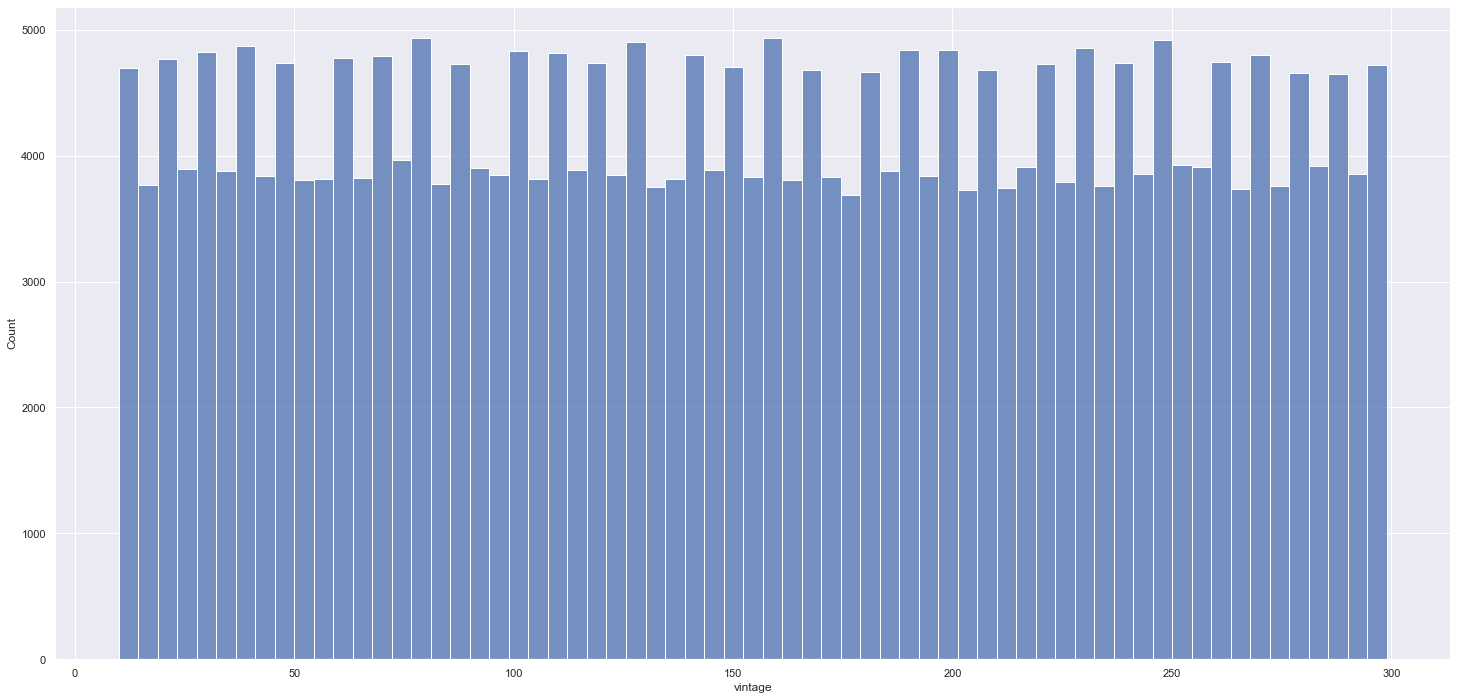

In [46]:
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

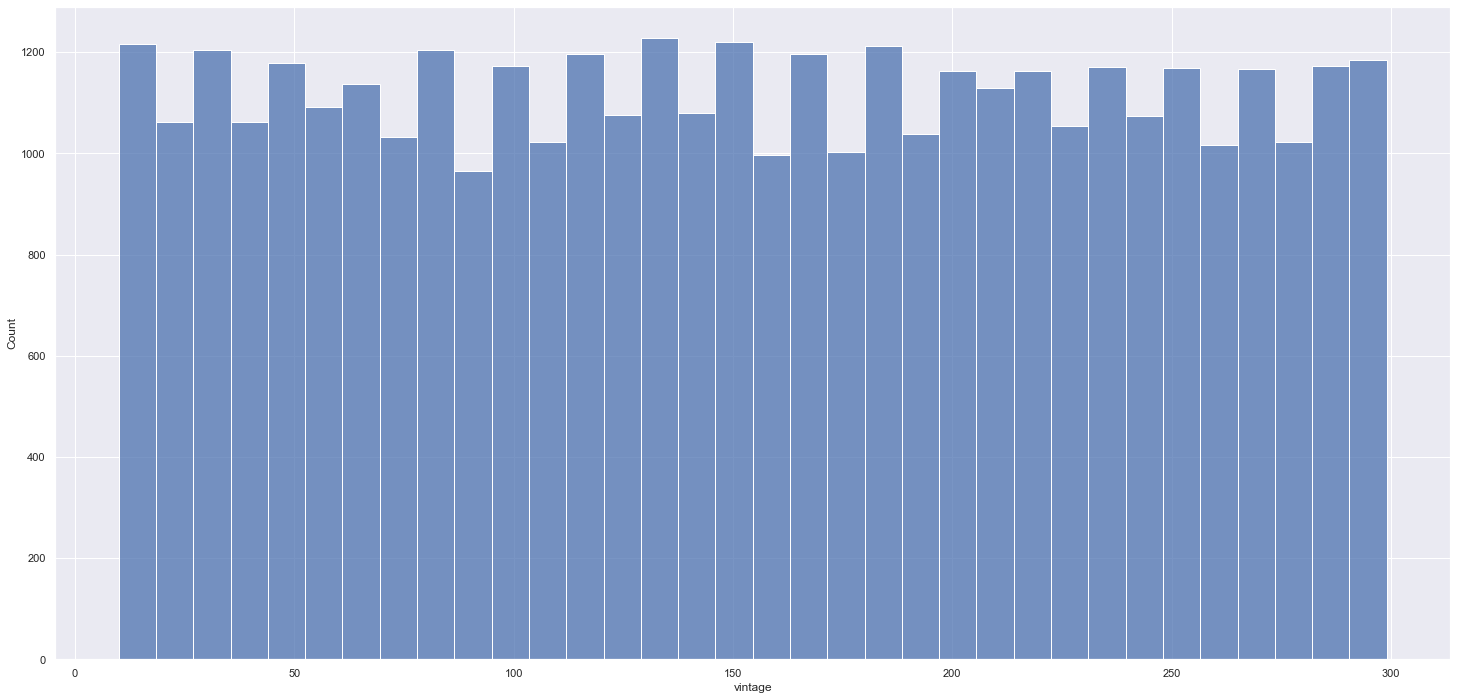

In [47]:
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

### 4.1.11 Gender

In [62]:
aux=df4[['gender', 'response']].value_counts( normalize=True ).reset_index()
aux.columns=[['gender','response','percentage']]
aux

,gender,response,percentage
0,Male,0,0.460889
1,Female,0,0.418391
2,Male,1,0.074012
3,Female,1,0.046708


/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


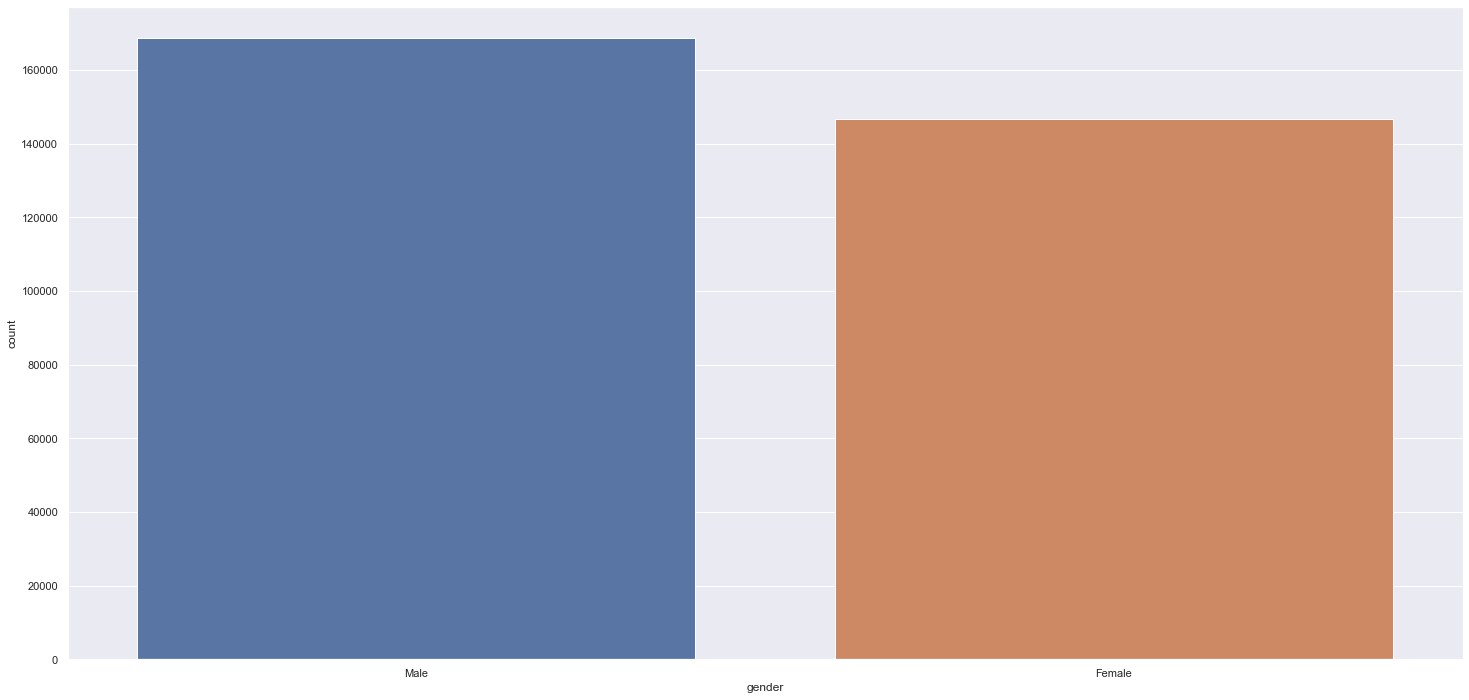

In [50]:
sns.countplot ( df4['gender']);

## 4.2 Bivariate Analysis

### **H1 -** Mulheres tem mais interesse em comprar seguro de veículos que homens.

**Falsa** - Homens tem mais interesse (61,31%) em comprar seguro de veículos do que mulheres (38,69%) 

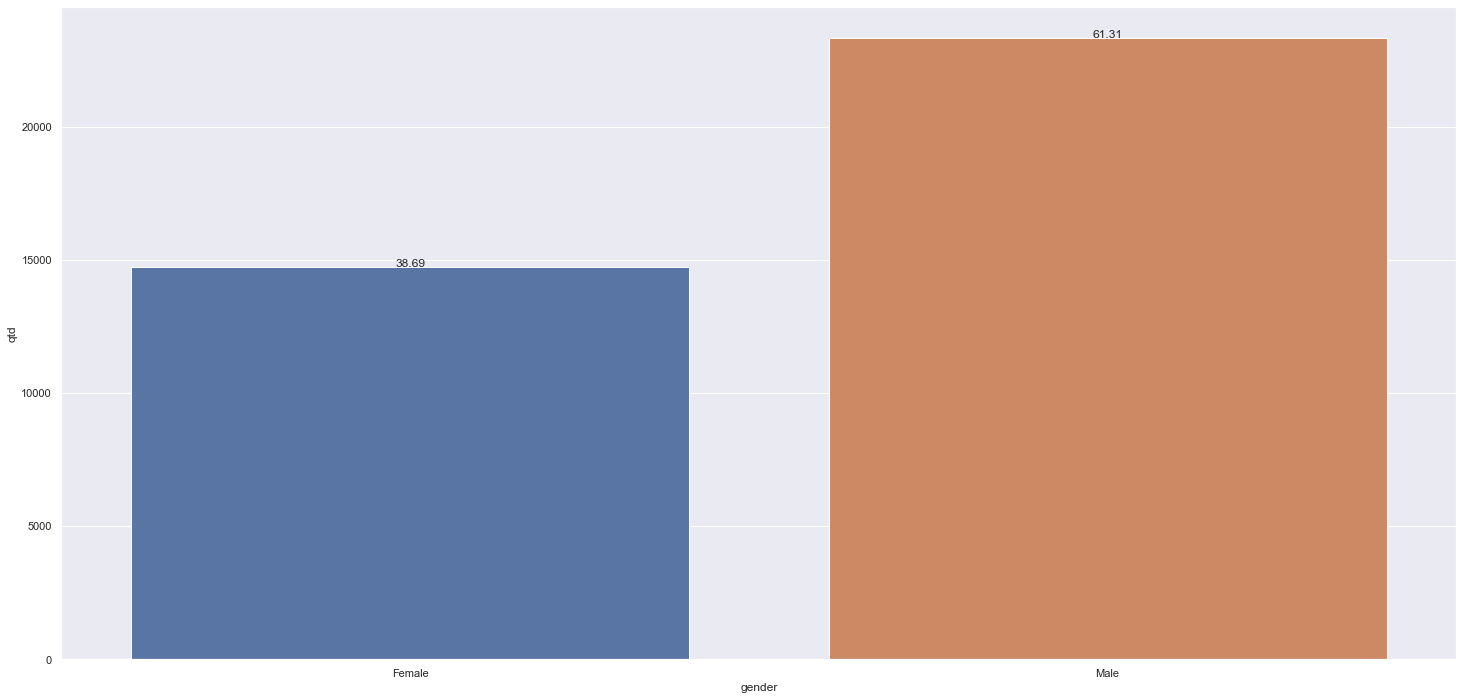

In [69]:
aux=df4[df4['response']==1]
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H2 - Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.

**Verdadeira** - Cliente com carros seminovos e novos correspondem a aproximadamente 90% dos interessados em adquirir um seguro de veículo


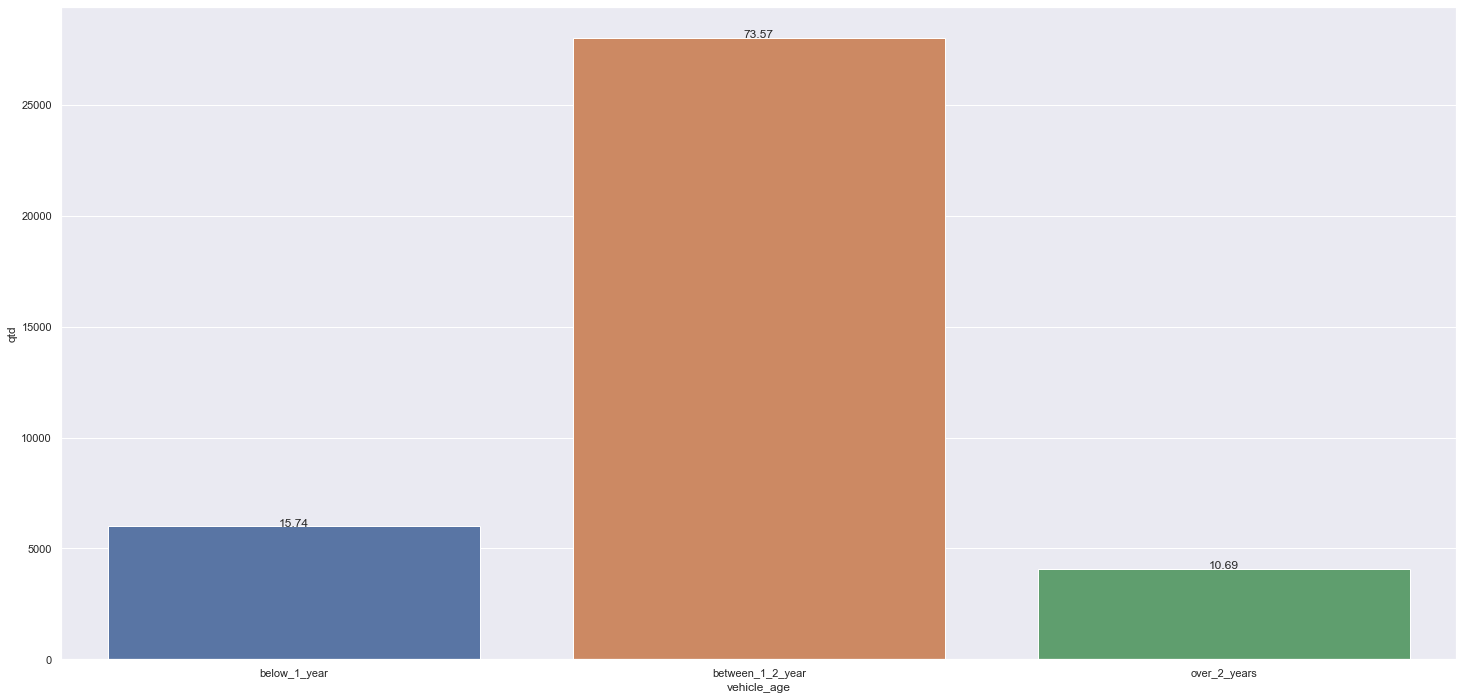

In [72]:
aux=df4[df4['response']==1]
aux=aux[['vehicle_age']].groupby('vehicle_age').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='vehicle_age',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H3 - Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.

**Falsa** - Uma pequena parcela de pessoas (0.01%), embora não tenham carteira de motorista estão interessados no seguro de veículos

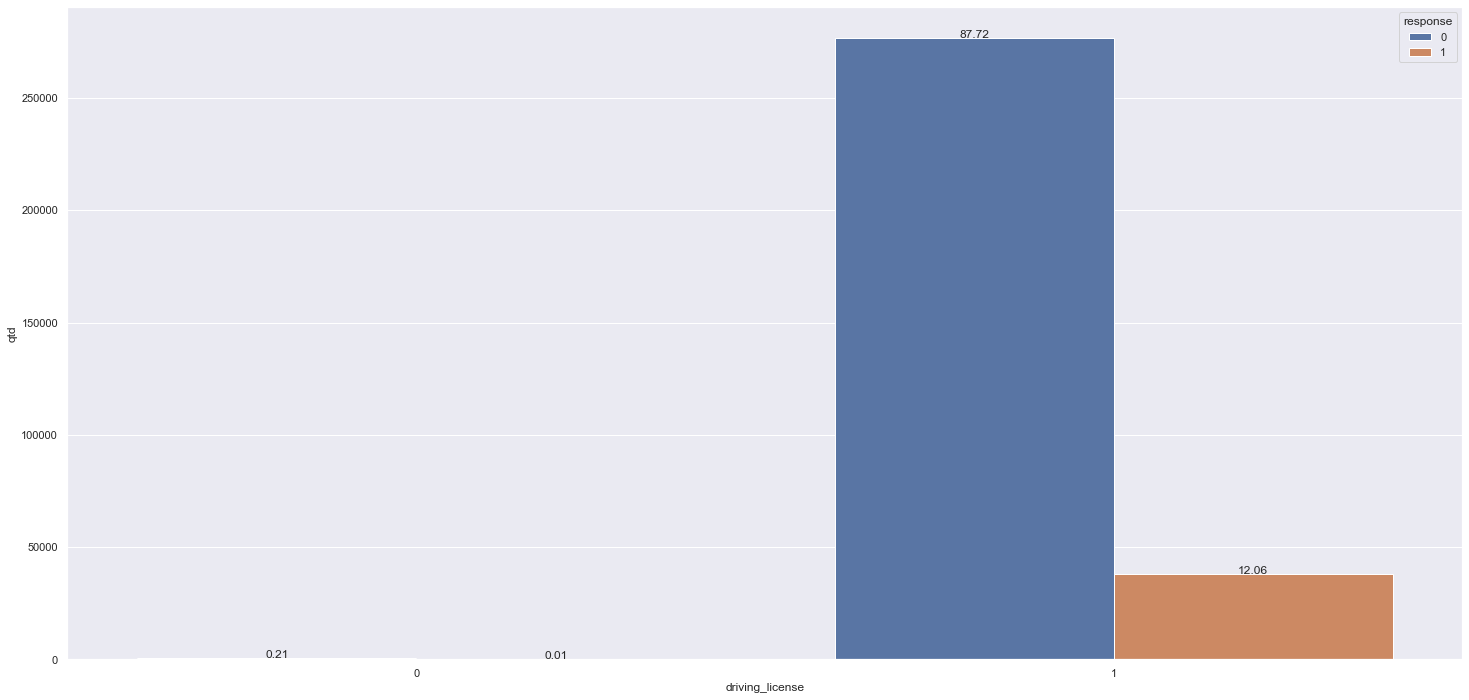

In [74]:
aux=df4[['driving_license','response']].groupby(['driving_license','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

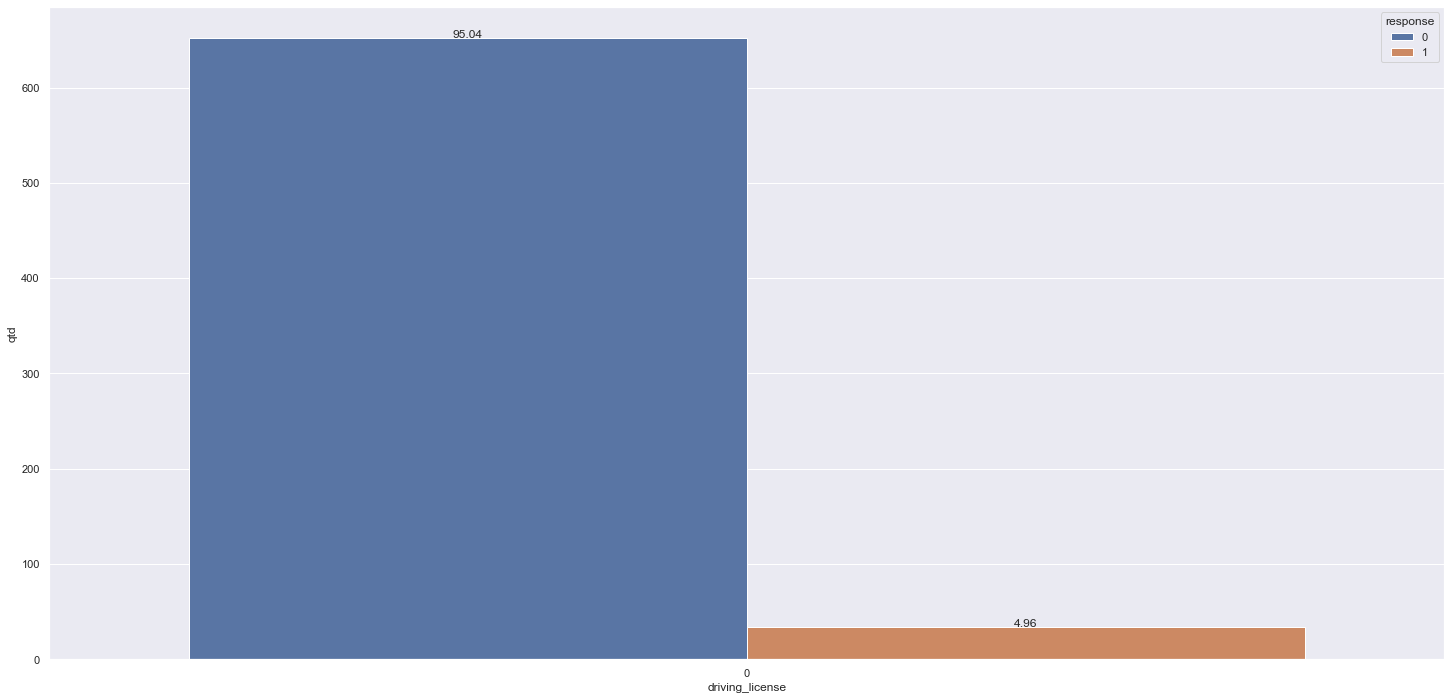

In [75]:
#Analise separada devida a pequena proporção
aux=aux[aux['driving_license']==0]
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H4 - Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.

**Verdadeira** - 98% dos clientes interessados no seguro ja sofreram algum tipo de acidentes.

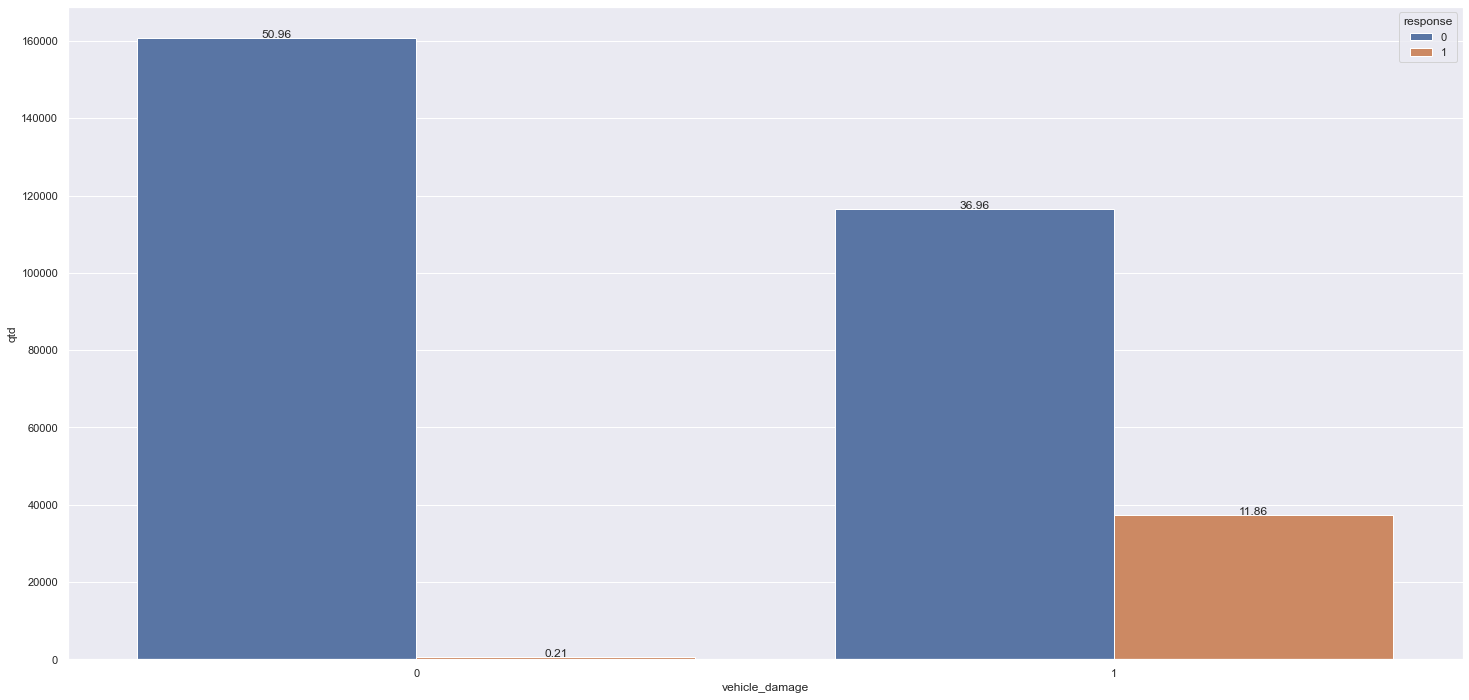

In [76]:
aux=df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

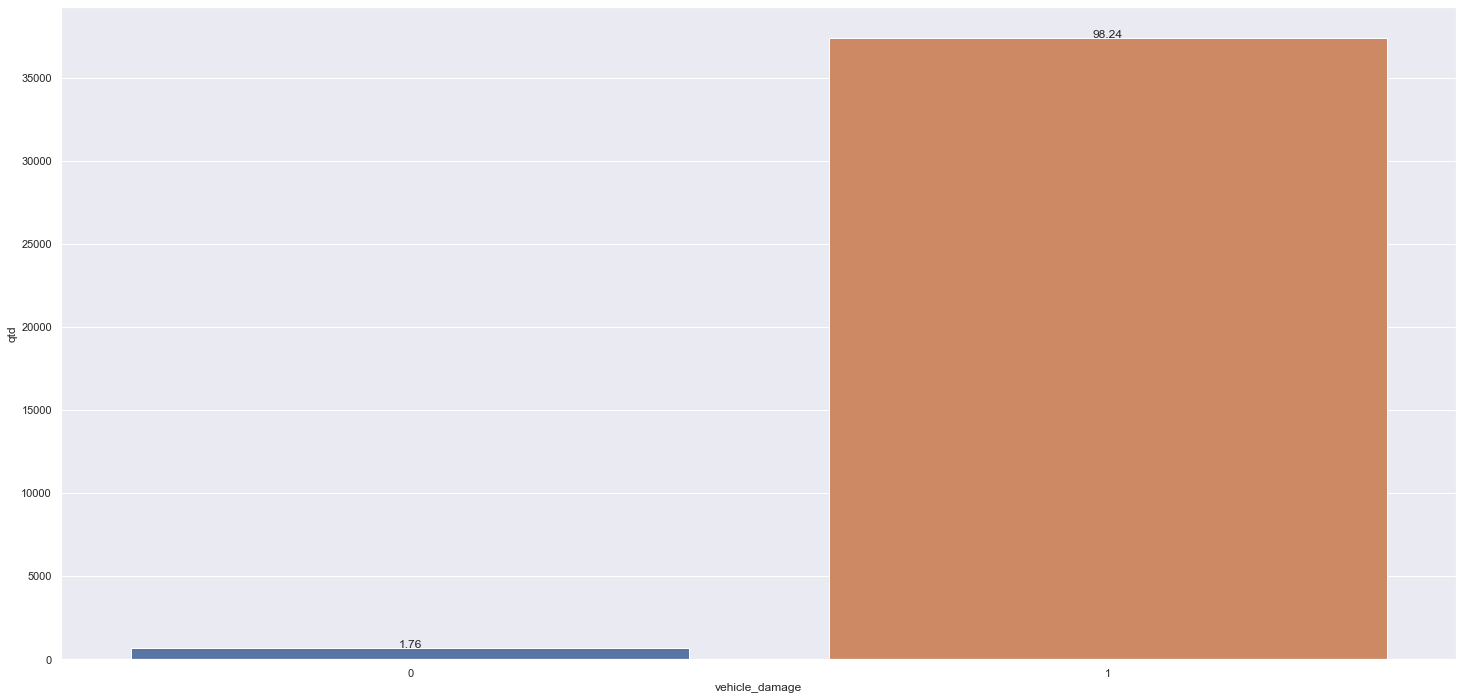

In [77]:
aux=aux[aux['response']==1]
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H5 - Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos.

**Verdadeira** - Aproximadamente 87% dos clientes interessados tem mais que 30 anos de idade

<AxesSubplot:xlabel='age', ylabel='qtd'>

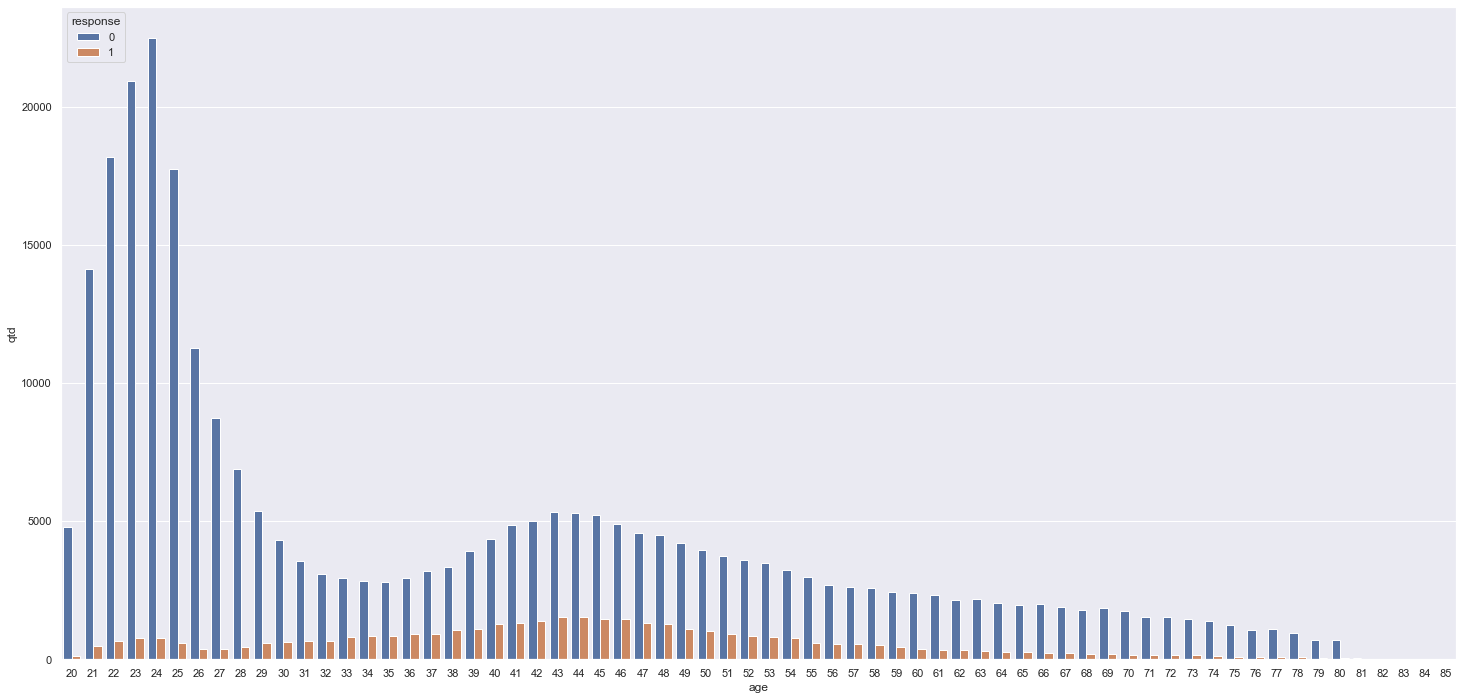

In [78]:
aux=df4[['age','response']].groupby(['age','response']).size().reset_index().rename(columns={0:'qtd'})
sns.barplot(data=aux,x='age',y='qtd',hue='response')

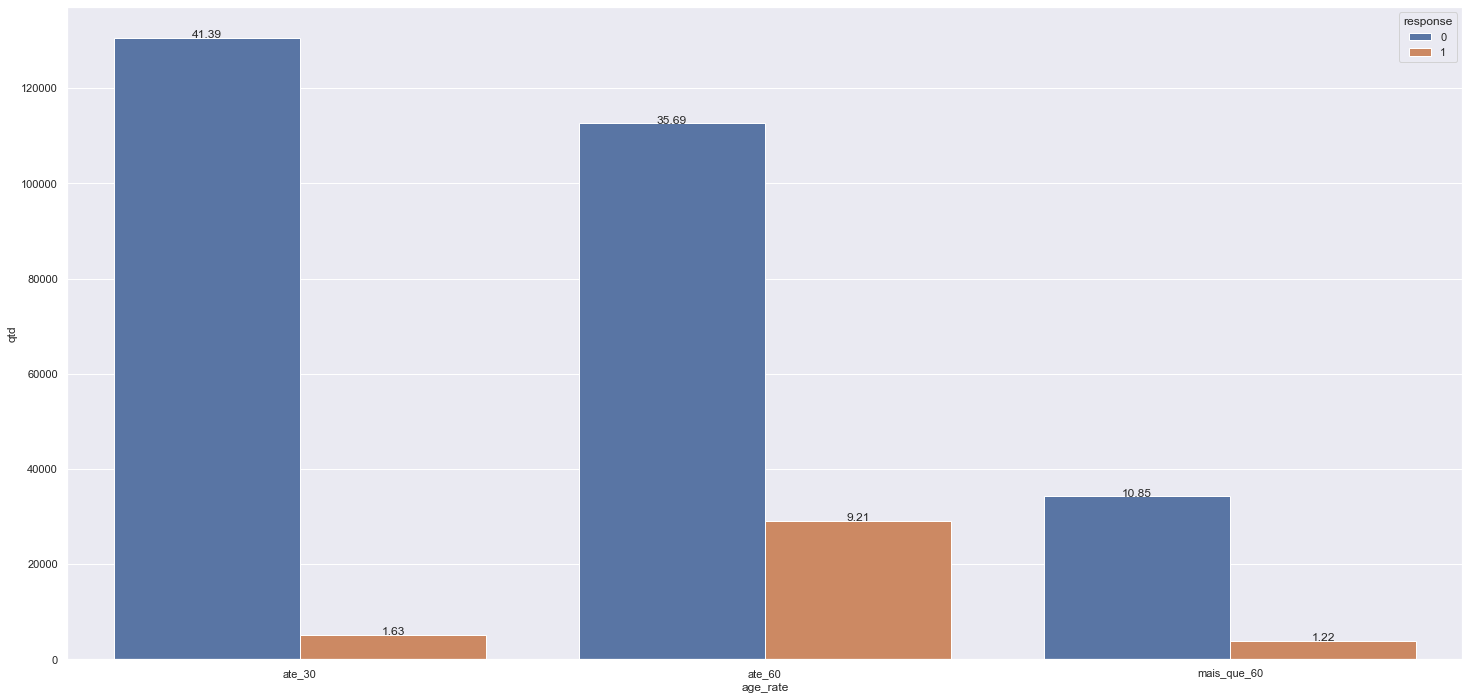

In [81]:
aux=df4.copy()
aux['age_rate']=df4['age'].apply(lambda x: 'ate_30' if x<30 else 'ate_60' if x>=30 and x<60 else 'mais_que_60')
aux=aux[['age_rate','response']].groupby(['age_rate','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='age_rate',y='qtd',hue='response');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

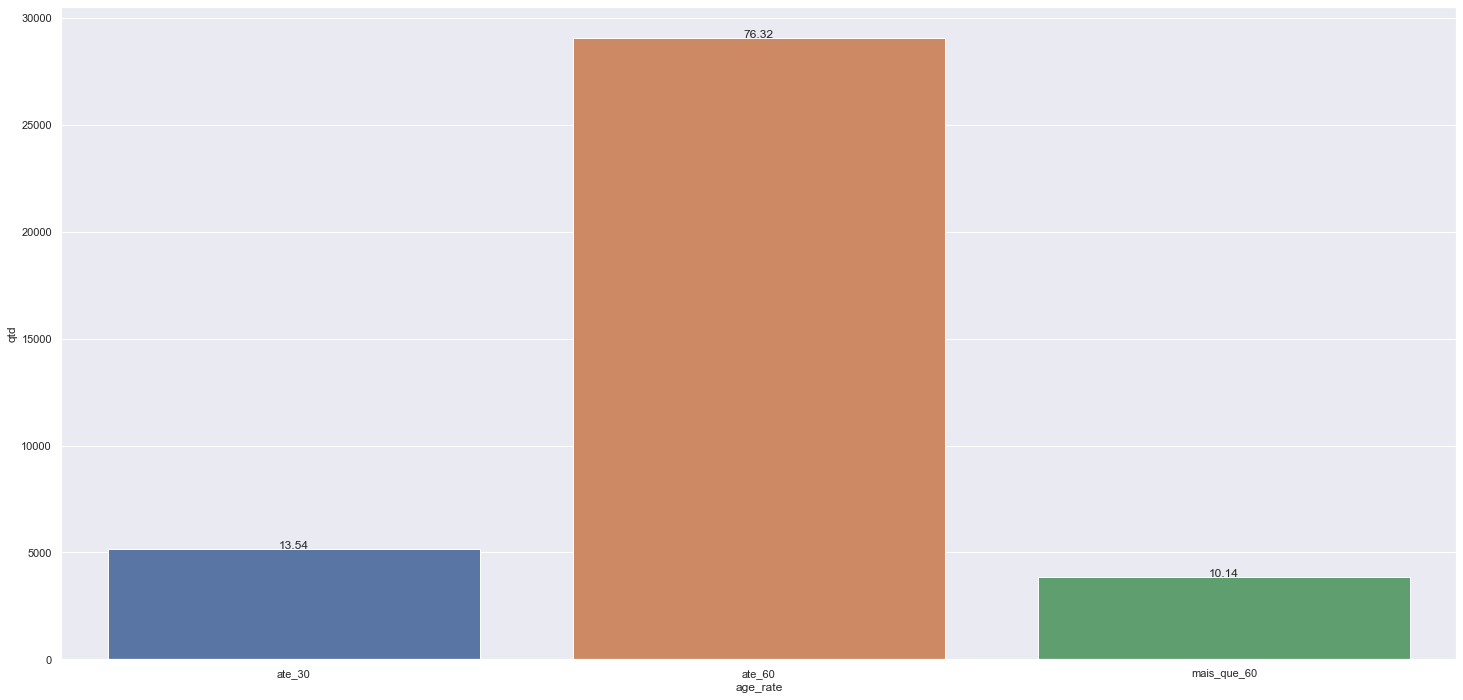

In [82]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='age_rate',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H6 - Clientes que pagaram entre 30000 e 40000 para serem premium no ano(Annual Premium) tem mais interesse em adquirir seguro de veículos.

**Verdadeira** - Clientes que pagaram entre 30000 e 40000 correspondem à 39,38 dos clientes interessados em seguro de veículos

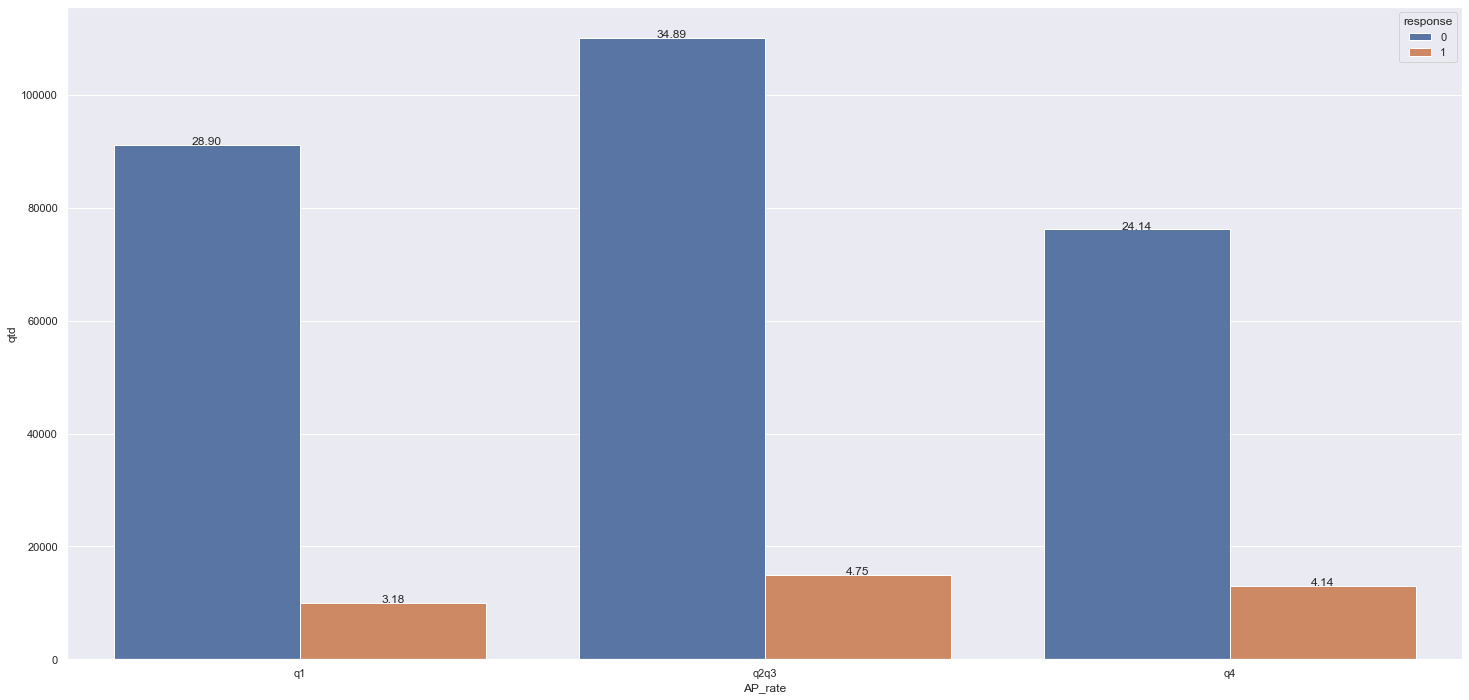

In [85]:
aux = df4.copy()
aux['AP_rate'] =aux['annual_premium'].apply(lambda x: 'q1' if x<30000 else 'q4' if x>40000 else 'q2q3')
aux=aux[['AP_rate','response']].groupby(['AP_rate','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='AP_rate',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

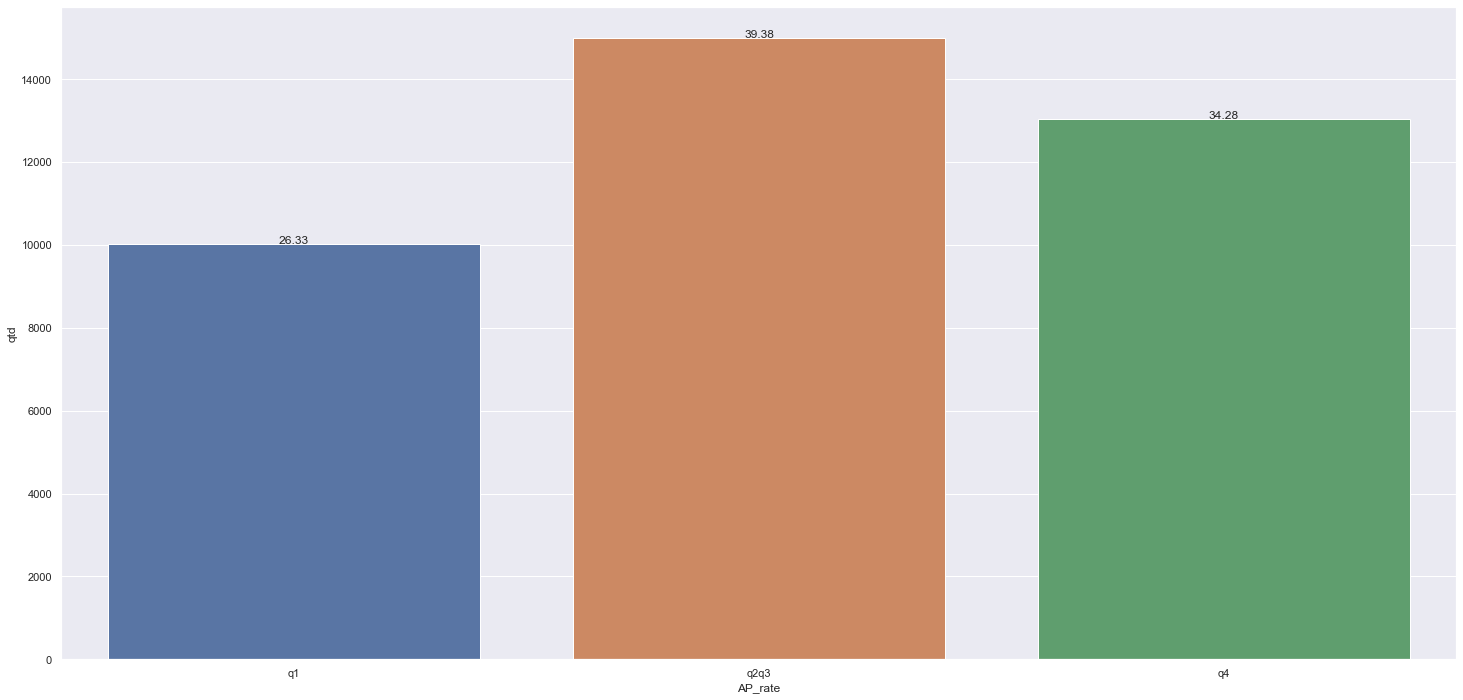

In [86]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='AP_rate',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H7 - Homens tem mais eventos de dano a veículos, do que mulheres.

**Verdadeira** - Homens representam 58,39% dos eventos de dano à veículos, enquanto as mulheres representam 41,61% dos eventos.

In [88]:
 pd.crosstab( df4['gender'], df4['vehicle_damage'] )

vehicle_damage,0,1
gender,,
Female,82636,64079
Male,78797,89937


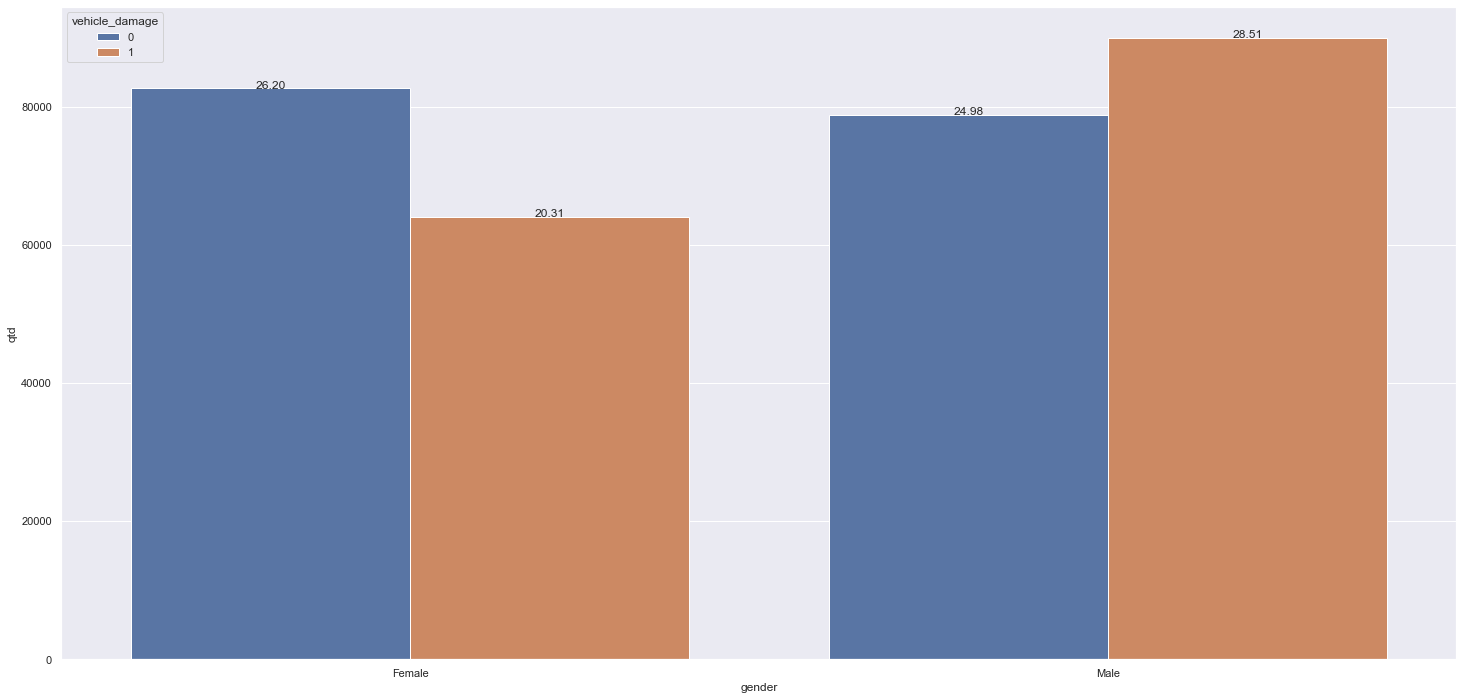

In [90]:
aux=df4[['vehicle_damage','gender']].groupby(['vehicle_damage','gender']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

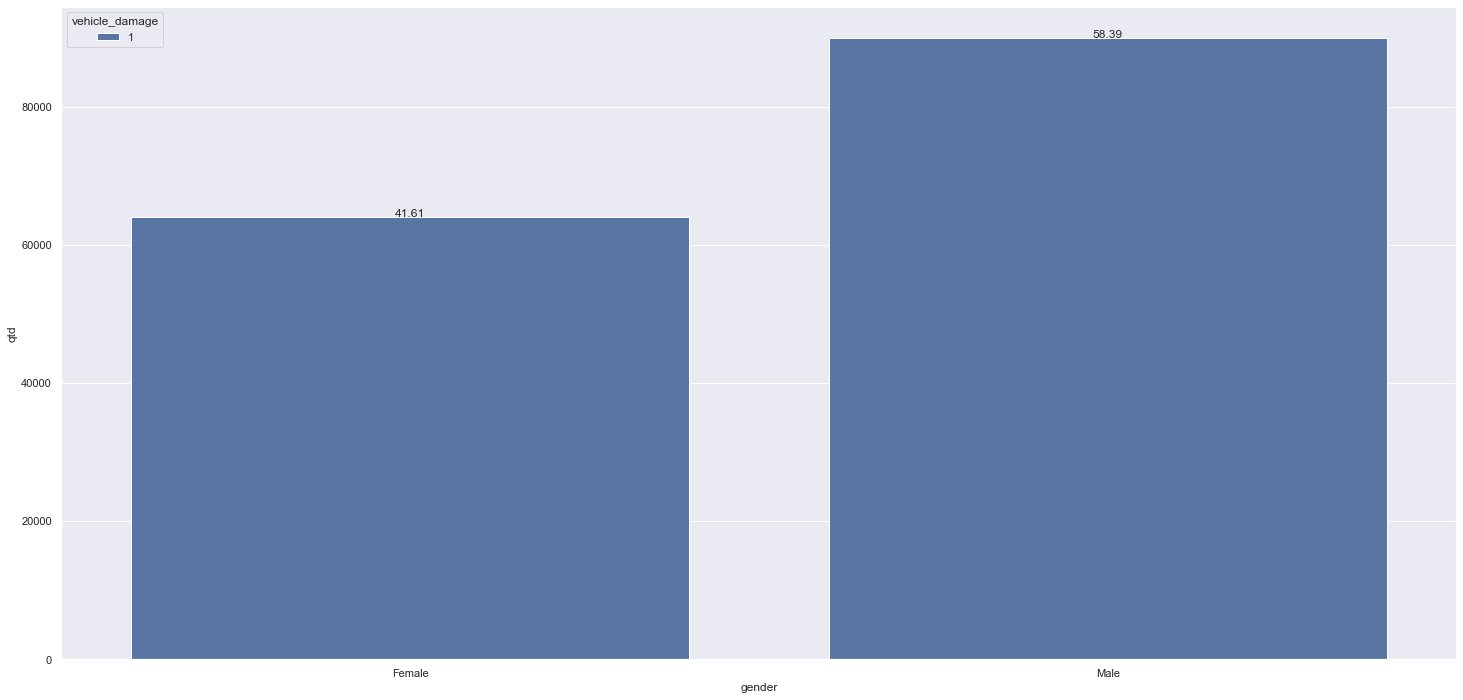

In [91]:
aux=aux[aux['vehicle_damage']==1]
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### 4.2.1 Summary of Hypotheses

In [96]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Alta'],  
      ['H2', 'Verdadeira', 'Alta'],  
      ['H3', 'Falsa', 'Baixa'],
      ['H4', 'Verdadeira', 'Alta'],
      ['H5', 'Verdadeira', 'Média'],
      ['H6', 'Verdadeira', 'Média'],
      ['H7', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Alta
H2           Verdadeira   Alta
H3           Falsa        Baixa
H4           Verdadeira   Alta
H5           Verdadeira   Média
H6           Verdadeira   Média
H7           Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.2 Numerical Attributes

<AxesSubplot:>

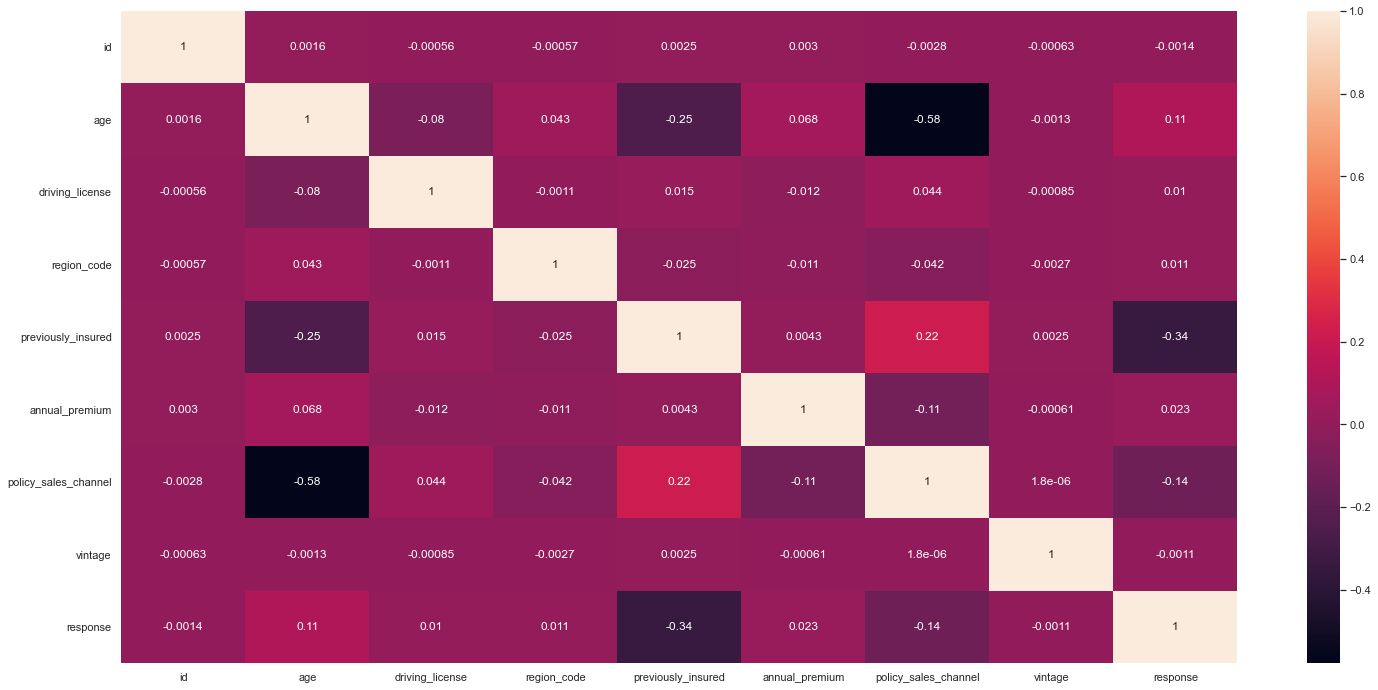

In [97]:
aux= num_attributes.corr()
sns.heatmap(aux,annot=True)

###  4.3.2. Categorical Attributes

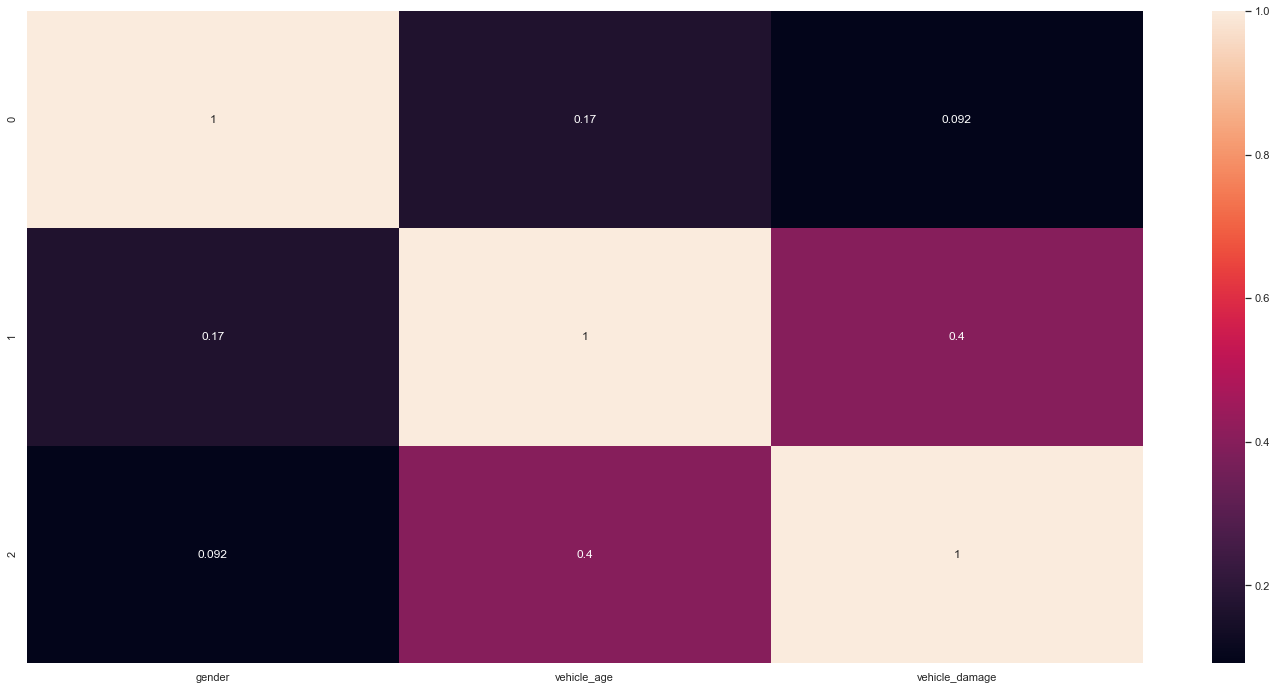

In [103]:
aux=pd.DataFrame(corr_cramer_v(cat_attributes))
sns.heatmap(aux,annot=True);

# 5.0. Data Preparation

In [24]:
df4=df3.copy()

In [25]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [26]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [27]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [28]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4. Validation Preparation

In [29]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection

## 6.1. Boruta Algorithm

In [29]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [30]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Feature Importance

In [31]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.273056
0                annual_premium    0.244318
0                           age    0.164726
0                   region_code    0.104973
0                vehicle_damage    0.066890
0          policy_sales_channel    0.060341
0            previously_insured    0.057736
0      vehicle_age_below_1_year    0.014053
0  vehicle_age_between_1_2_year    0.006320
0                        gender    0.004865
0      vehicle_age_over_2_years    0.002237
0               driving_license    0.000485


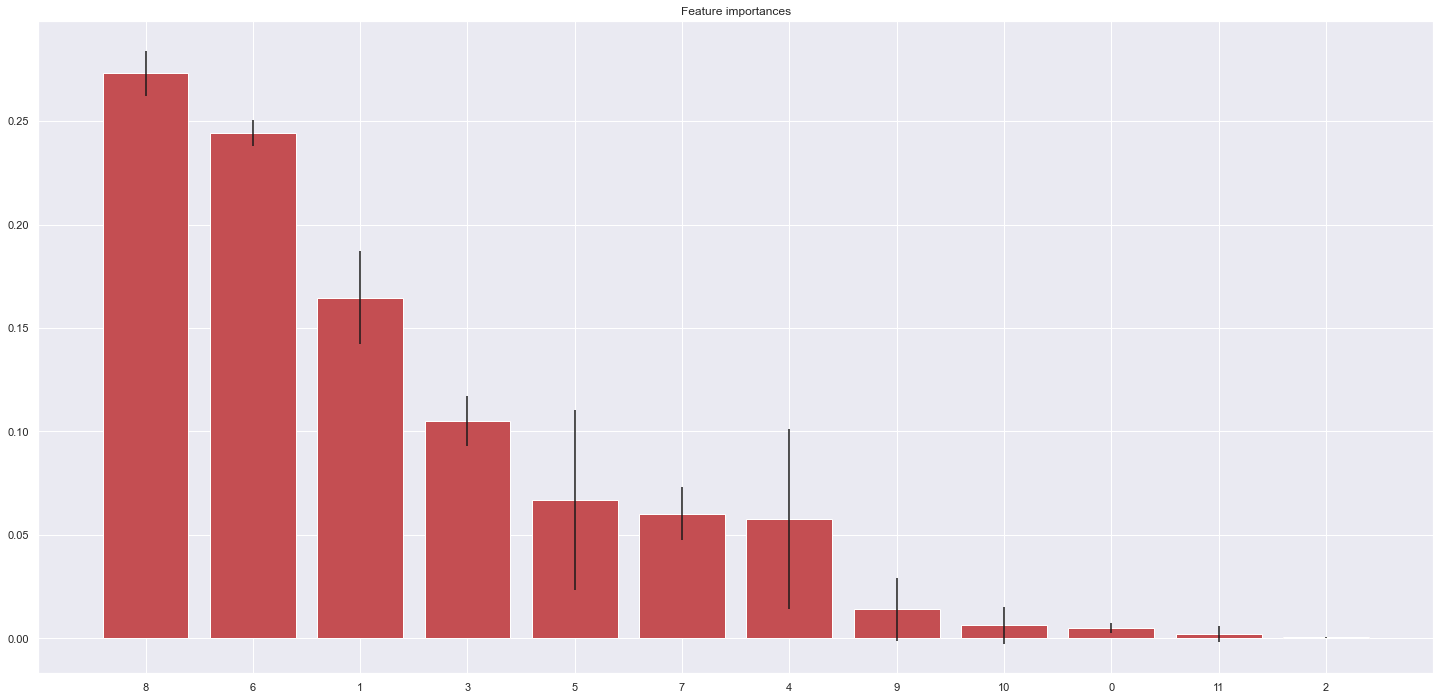

In [32]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()



# 7.0. Machine Learning Modelling

In [30]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']


In [31]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

In [32]:
models_performance=pd.DataFrame()


## 7.1 Comparing Models

In [37]:
models_list=[
                xgb.XGBClassifier(objective='binary:logistic',
                                  eval_metric='error',
                                  n_estimators=100,
                                  eta=0.01,
                                  max_depth=10,
                                  subsample=0.7,
                                  colsample_bytree=0.9),
                LogisticRegression(penalty='l2', solver='newton-cg'),
                GaussianNB(),
                RandomForestClassifier(n_estimators=100,random_state=36),
                KNeighborsClassifier(n_jobs=-1),
                LGBMClassifier()
        ]

models_performance=models_performance.append(models_train(models_list,x_train,y_train,x_val,y_val,'predict_proba','binaryClass',0))
models_performance

XGBClassifier
LogisticRegression
GaussianNB
RandomForestClassifier
KNeighborsClassifier
LGBMClassifier


,Index,Model,ROC AUC,Top K Score
0,0,XGBClassifier,0.855165,0.878657
0,0,LogisticRegression,0.817667,0.87867
0,0,GaussianNB,0.824887,0.636955
0,0,RandomForestClassifier,0.83053,0.865013
0,0,KNeighborsClassifier,0.757469,0.854714
0,0,LGBMClassifier,0.854901,0.878132


## 7.2. KNN Classifier

In [38]:
model_knn = models_list[4].fit(x_train,y_train)
yhat_proba_knn = model_knn.predict_proba(x_val)

## 7.3. Logistic Regression

In [39]:
model_rLog = models_list[1].fit(x_train,y_train)
yhat_proba_rLog = model_rLog.predict_proba(x_val)

## 7.4. Naive Bayes



In [40]:
model_naiveBayes =models_list[2].fit(x_train,y_train)
yhat_proba_naiveBayes=model_naiveBayes.predict_proba(x_val)

## 7.5. Random Forest

In [41]:
model_rf = models_list[3].fit(x_train,y_train)
yhat_proba_rf= model_rf.predict_proba(x_val)

## 7.6 LGBM

In [42]:
model_lgbm = models_list[5].fit(x_train,y_train)
yhat_proba_lgbm = model_lgbm.predict_proba(x_val)

## 7.7 XGBoost

In [43]:
model_xgb =  models_list[0].fit(x_train,y_train)
yhat_proba_xgb=model_xgb.predict_proba(x_val)

/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## 7.8 Models Perfomance

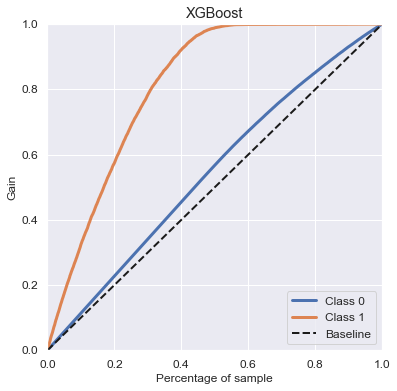

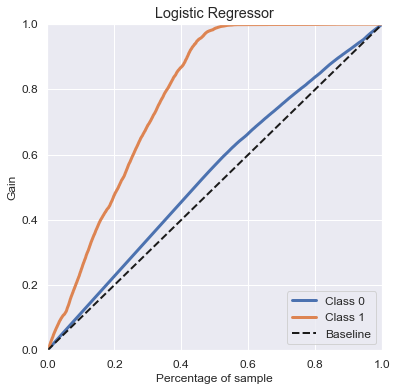

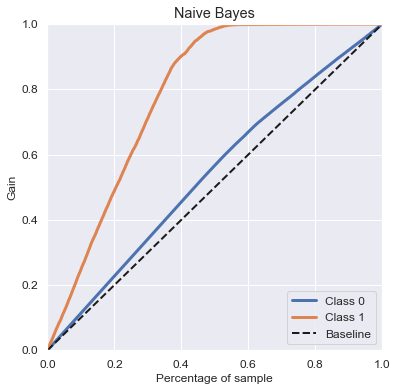

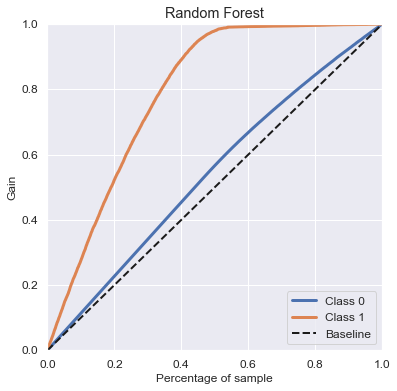

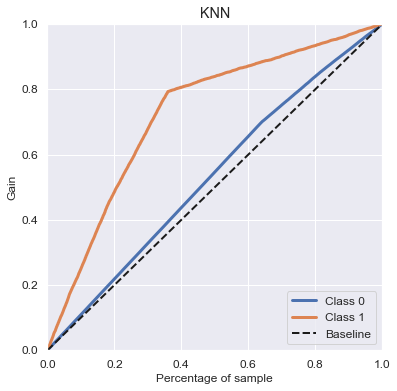

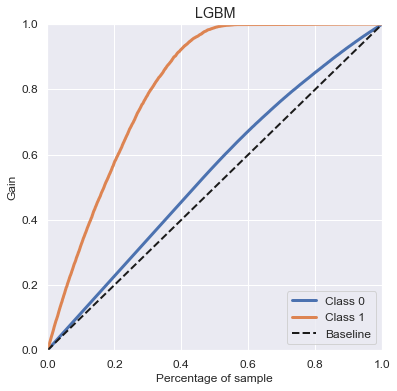

In [44]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_xgb,figsize =(6,6),title='XGBoost');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_rLog,figsize =(6,6),title='Logistic Regressor');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_naiveBayes,figsize =(6,6),title='Naive Bayes');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_rf,figsize =(6,6),title='Random Forest');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_knn,figsize =(6,6),title='KNN');
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm,figsize =(6,6),title='LGBM');

## 8.0 Cross validation

## 8.1 XGBoost

In [46]:
models_performance=models_performance.append(cross_validation(5,'XGBoost',model_xgb,x_train,y_train,metrics))

NameError: name 'metrics' is not defined

## 8.2 Logistic Regression

In [53]:
models_performance=models_performance.append(cross_validation(5,'Logistic Regression',model_rLog,x_train,y_train,binary_class_metrics)) 

NameError: name 'binary_class_metrics' is not defined

## 8.3 Naive Bayes

In [ ]:
models_performance=models_performance.append(cross_validation(5,'GaussianNB',model_naiveBayes,x_train,y_train,binary_class_metrics)) 

## 8.4 Random Forest


In [ ]:
models_performance=models_performance.append(cross_validation(5,'Random Forest',model_rf,x_train,y_train,binary_class_metrics)) 

## 8.5 KNN

In [ ]:
models_performance=models_performance.append(cross_validation(5,'KNN',model_knn,x_train,y_train,binary_class_metrics)) 

## 8.6 LGBM

In [ ]:
models_performance=models_performance.append(cross_validation(5,'LGBM',model_lgbm,x_train,y_train,binary_class_metrics)) 

## 8.0. Performance Metrics

In [57]:
def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

In [58]:
def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [59]:
# copy dataframe
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df8, k=20 )

# compute recall at k
recall_at_15, data = recall_at_k( df8, k=15 )

In [60]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score

y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 is in top 2
                    [0.3, 0.4, 0.2],  # 1 is in top 2
                    [0.2, 0.4, 0.3],  # 2 is in top 2
                    [0.7, 0.2, 0.1]]) # 2 isn't in top 2

top_k_accuracy_score(y_true, y_score, k=2)

0.75

In [61]:
y_true = np.array( [1, 0, 1, 1, 0, 1, 0, 0] )
y_score = np.array( [])

# Cummulative Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

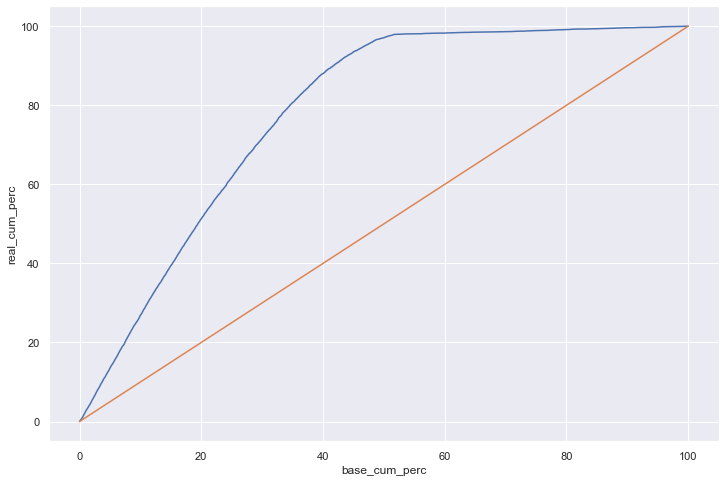

In [62]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

# Lift Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

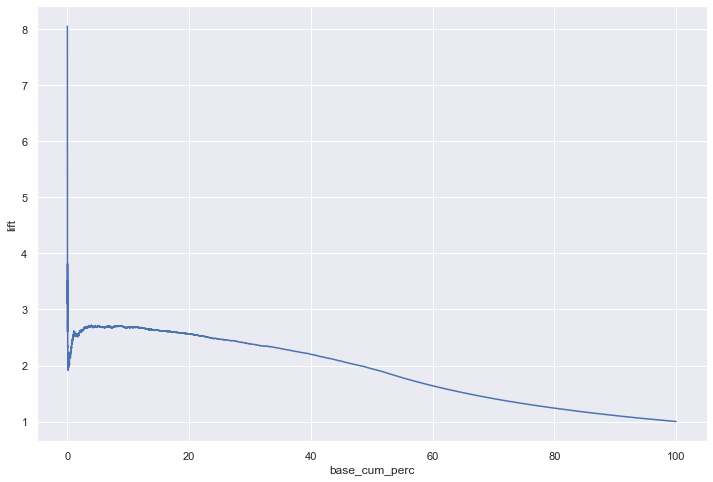

In [63]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

# ROI Curve Manually

In [64]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve


#plt.figure( figsize=(12,8))
#sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [65]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,153,0.9,5508.0,612,0.002007,4896.0
8,0.80,296,0.8,9472.0,1184,0.005891,8288.0
7,0.70,599,0.7,16772.0,2396,0.013749,14376.0
6,0.60,1192,0.6,28608.0,4768,0.029388,23840.0
5,0.50,2066,0.5,41320.0,8264,0.056493,33056.0
4,0.40,3465,0.4,55440.0,13860,0.101952,41580.0
3,0.30,5356,0.3,64272.0,21424,0.172221,42848.0
2,0.20,6950,0.2,55600.0,27800,0.263402,27800.0
1,0.10,8246,0.1,32984.0,32984,0.371586,0.0
0,0.01,47899,0.0,0.0,191596,1.000000,-191596.0


<AxesSubplot:xlabel='base', ylabel='revenue'>

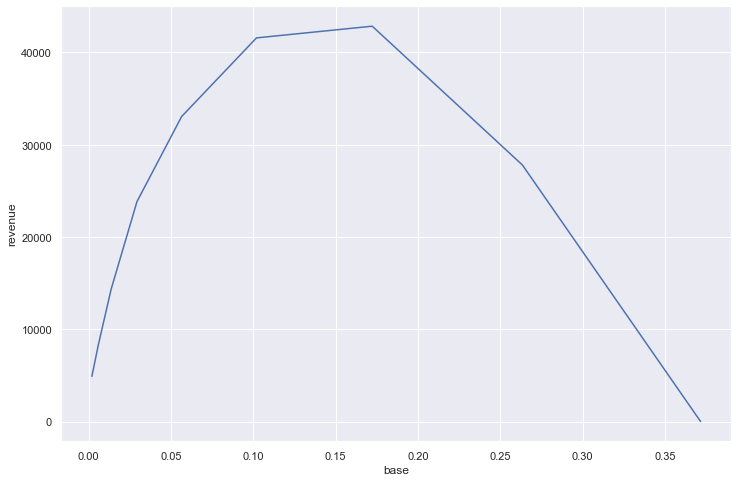

In [66]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )

# 9.0. Deploy to Production

In [67]:
# Save trained model
pickle.dump( et, open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_health_insurance.pkl', 'wb' ) )
# pickle.dump( lr_model, open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_linear_regression.pkl', 'wb' ) )

## 9.1. Health Insurance Class

In [106]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path = '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [111]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
path = '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
model = pickle.load( open( path + 'src/models/model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/heathinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

KeyboardInterrupt: 

## 9.3. API Tester

In [281]:
import requests

In [282]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [283]:
df_test = df_test.sample(10)

In [284]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [285]:
data

'[{"id": 74147, "gender": "Female", "age": 26, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 43343.0, "policy_sales_channel": 124.0, "vintage": 288, "response": 0}, {"id": 322299, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 45209.0, "policy_sales_channel": 124.0, "vintage": 230, "response": 0}, {"id": 331804, "gender": "Female", "age": 43, "driving_license": 1, "region_code": 15.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 26894.0, "policy_sales_channel": 26.0, "vintage": 171, "response": 0}, {"id": 363080, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "annual_premium": 41405.0, "policy_sales_channel": 23.

In [286]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [287]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
3,363080,0.138780,0.369231,1,0.187988,0,below_1_year,0,0.492486,23.0,0.930796,0,0.050289
7,318230,0.138780,0.230769,1,0.187988,0,below_1_year,0,-0.511883,26.0,0.615917,0,0.044430
0,74147,0.099756,0.092308,1,0.187988,0,below_1_year,0,0.669245,124.0,0.961938,0,0.044017
1,322299,0.138780,0.369231,1,0.187988,0,below_1_year,0,0.839437,124.0,0.761246,0,0.041979
9,107812,0.138780,0.338462,1,0.187988,0,below_1_year,0,3.605010,26.0,0.640138,1,0.037594
